<a href="https://colab.research.google.com/github/AImSecure/Laboratory3/blob/main/lab/notebooks/Lab3_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 3 — Anomaly Detection

**Course:** AI and Cybersecurity  
**Project:** Supervised vs Unsupervised Anomaly Detection  
**Objective:** Apply Shallow and Deep Learning anomaly detection techniques to build an Intrusion Detection System (IDS).

> **Key Constraint:** We do not use labels to train supervised models directly. Instead, we evaluate whether unsupervised algorithms can automatically detect anomalous patterns.

## Setup

In [8]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12


In [9]:






# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [10]:
# --- Import libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, silhouette_score, silhouette_samples
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set visual style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

In [11]:
# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

### Colab Pro

In [12]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 10 16:07:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [14]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory3'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/


In [16]:
# --- Helper function for saving plots ---

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (without extension).
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.
        close_fig (bool, optional): Whether to close the figure after saving. Defaults to False.

    Returns:
        None
    """
    os.makedirs(path, exist_ok=True)
    full_path = os.path.join(path, f"{filename}.{fmt}")
    fig.savefig(full_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {full_path}")

## Task 1 — Dataset Characterization and Preprocessing

In this task, we explore the dataset structure and prepare features for anomaly detection:
1. **Exploration** — Understand feature types and label distributions
2. **Preprocessing** — Handle categorical features, normalize numerical features
3. **Domain Analysis** — Use heatmaps to identify feature-attack correlations

In [17]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

### Explore the dataset

Before preprocessing, we explore the data to understand the available features.

In [18]:
# Load Datasets
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

print("Files loaded successfully.")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape:  {test_df.shape}")

Files loaded successfully.
Train dataset shape: (18831, 43)
Test dataset shape:  (5826, 43)


In [19]:
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18831 entries, 0 to 18830
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18831 non-null  int64  
 1   protocol_type                18831 non-null  object 
 2   service                      18831 non-null  object 
 3   flag                         18831 non-null  object 
 4   src_bytes                    18831 non-null  int64  
 5   dst_bytes                    18831 non-null  int64  
 6   land                         18831 non-null  int64  
 7   wrong_fragment               18831 non-null  int64  
 8   urgent                       18831 non-null  int64  
 9   hot                          18831 non-null  int64  
 10  num_failed_logins            18831 non-null  int64  
 11  logged_in                    18831 non-null  int64  
 12  num_compromised              18831 non-null  int64  
 13  root_shell      

In [21]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     5826 non-null   int64  
 1   protocol_type                5826 non-null   object 
 2   service                      5826 non-null   object 
 3   flag                         5826 non-null   object 
 4   src_bytes                    5826 non-null   int64  
 5   dst_bytes                    5826 non-null   int64  
 6   land                         5826 non-null   int64  
 7   wrong_fragment               5826 non-null   int64  
 8   urgent                       5826 non-null   int64  
 9   hot                          5826 non-null   int64  
 10  num_failed_logins            5826 non-null   int64  
 11  logged_in                    5826 non-null   int64  
 12  num_compromised              5826 non-null   int64  
 13  root_shell        

In [23]:
# --- Identify Categorical and Numerical Features ---

# We exclude the label columns from the feature lists
label_cols = ['label', 'binary_label']

# Identify categorical columns (type 'object')
categorical_cols = train_df.select_dtypes(include=['object']).columns.drop(label_cols, errors='ignore').to_list()

# Identify numerical columns (any number type)
numerical_cols = train_df.select_dtypes(include=np.number).columns.drop(label_cols, errors='ignore').to_list()

print(f"\n--- Feature Types ---")
print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {len(numerical_cols)} (First 5: {numerical_cols[:5]}...)")
print(f"Label features: {label_cols}")


--- Feature Types ---
Categorical features: ['protocol_type', 'service', 'flag']
Numerical features: 38 (First 5: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment']...)
Label features: ['label', 'binary_label']


In [24]:
for column in ['protocol_type', 'service', 'flag']:
  print(f"{column}: {train_df[column].unique()}")

protocol_type: ['udp' 'icmp' 'tcp']
service: ['private' 'eco_i' 'daytime' 'http' 'exec' 'smtp' 'ftp_data' 'ssh'
 'domain_u' 'other' 'netbios_ns' 'urp_i' 'ecr_i' 'ftp' 'discard' 'ntp_u'
 'http_443' 'telnet' 'systat' 'Z39_50' 'name' 'finger' 'iso_tsap'
 'courier' 'netstat' 'hostnames' 'csnet_ns' 'efs' 'link' 'ctf' 'supdup'
 'auth' 'X11' 'klogin' 'IRC' 'time' 'domain' 'pop_3' 'whois' 'uucp_path'
 'vmnet' 'pop_2' 'netbios_dgm' 'nntp' 'bgp' 'uucp' 'gopher' 'nnsp'
 'kshell' 'sql_net' 'urh_i' 'ldap' 'mtp' 'sunrpc' 'rje' 'echo' 'login'
 'netbios_ssn' 'imap4' 'red_i' 'printer' 'http_8001' 'pm_dump'
 'remote_job' 'shell']
flag: ['SF' 'S0' 'REJ' 'RSTO' 'RSTR' 'S2' 'S1' 'SH' 'RSTOS0' 'S3' 'OTH']


In [25]:
# --- Check Label Distribution ---
print("\n--- Attack Label Distribution (Train) ---")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Train) ---")
print(train_df['binary_label'].value_counts(normalize=True) * 100)

print("\n--- Attack Label Distribution (Test) ---")
print(test_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Test) ---")
print(test_df['binary_label'].value_counts(normalize=True) * 100)


--- Attack Label Distribution (Train) ---
label
normal    71.414158
dos       15.469173
probe     12.155488
r2l        0.961181
Name: proportion, dtype: float64

--- Binary Label Distribution (Train) ---
binary_label
0    71.414158
1    28.585842
Name: proportion, dtype: float64

--- Attack Label Distribution (Test) ---
label
dos       44.232750
normal    36.937865
probe     18.829386
Name: proportion, dtype: float64

--- Binary Label Distribution (Test) ---
binary_label
1    63.062135
0    36.937865
Name: proportion, dtype: float64


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_multiclass_label_distribution.png


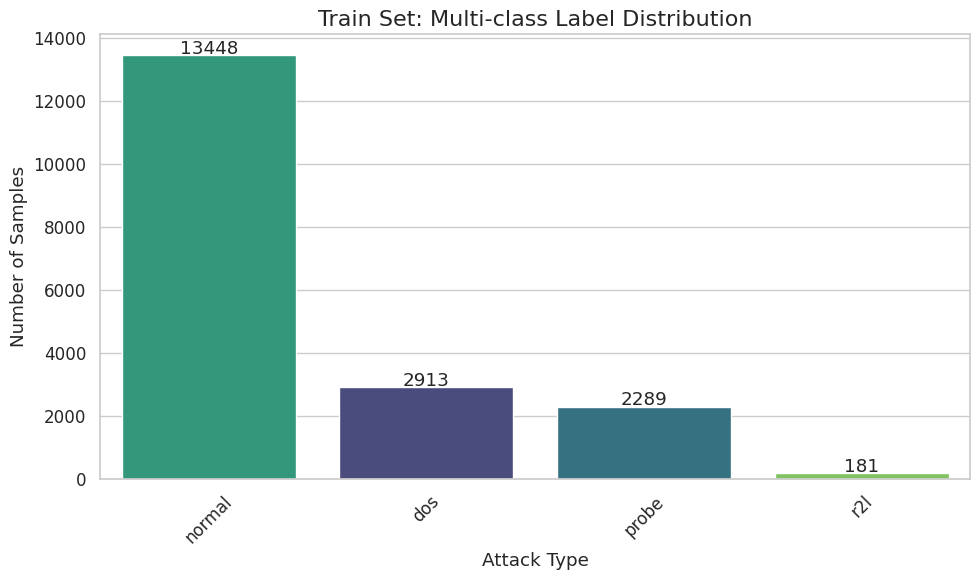

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_binary_label_distribution.png


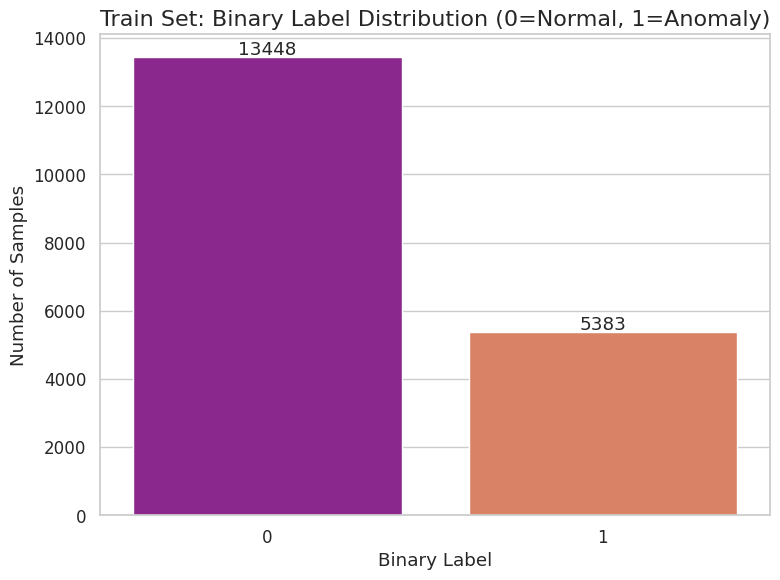

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_multiclass_label_distribution.png


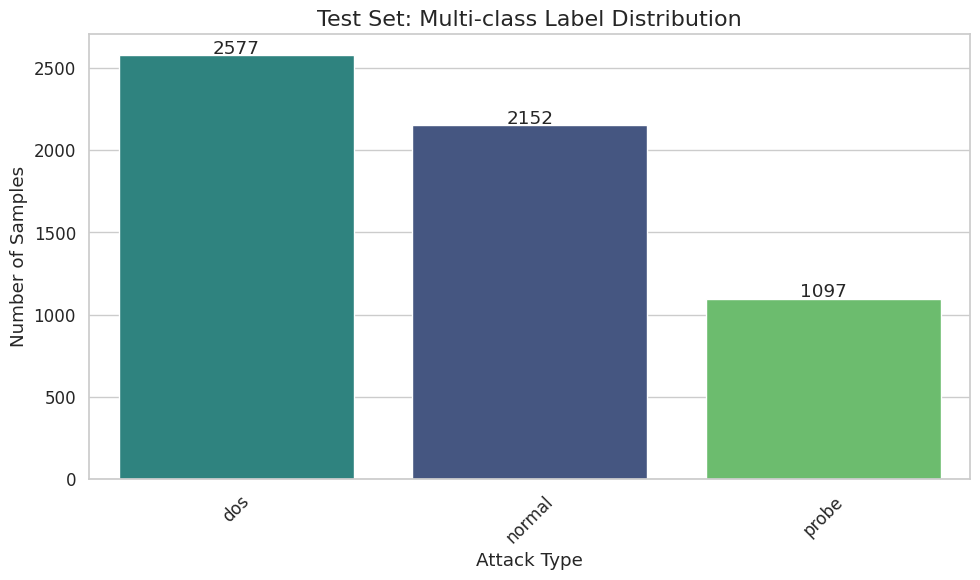

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_binary_label_distribution.png


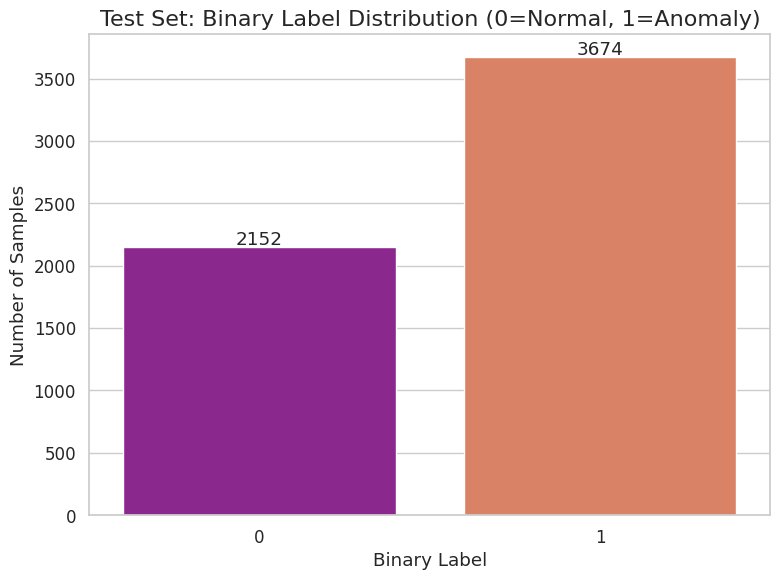

In [26]:
# Helper function to add count labels on bars
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )

# --- Plot 1: Train Set - Multi-class Label Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=train_df,
    x='label',
    palette='viridis',
    order=train_df['label'].value_counts().index,
    hue='label',
    legend=False
)
plt.title('Train Set: Multi-class Label Distribution', fontsize=16)
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
add_counts(ax)
plt.tight_layout() # Adjust layout for this specific figure
save_plot(plt.gcf(), 'train_multiclass_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 2: Train Set - Binary Label Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=train_df,
    x='binary_label',
    palette='plasma',
    hue='binary_label',
    legend=False
)
plt.title('Train Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
plt.xlabel('Binary Label')
plt.ylabel('Number of Samples')
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'train_binary_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 3: Test Set - Multi-class Label Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=test_df,
    x='label',
    palette='viridis',
    order=test_df['label'].value_counts().index,
    hue='label',
    legend=False
)
plt.title('Test Set: Multi-class Label Distribution', fontsize=16)
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'test_multiclass_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 4: Test Set - Binary Label Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=test_df,
    x='binary_label',
    palette='plasma',
    hue='binary_label',
    legend=False
)
plt.title('Test Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
plt.xlabel('Binary Label')
plt.ylabel('Number of Samples')
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'test_binary_label_distribution', path=save_dir, close_fig=False)
plt.show()

In [27]:
print("\n--- Value Counts for Training Data ---")
for col in ['protocol_type', 'service', 'flag']:
    print(f"\n{col} (Train):")
    print(train_df[col].value_counts())

print("\n--- Value Counts for Test Data ---")
for col in ['protocol_type', 'service', 'flag']:
    print(f"\n{col} (Test):")
    print(test_df[col].value_counts())


--- Value Counts for Training Data ---

protocol_type (Train):
protocol_type
tcp     14204
udp      3010
icmp     1617
Name: count, dtype: int64

service (Train):
service
http         7831
private      2036
domain_u     1820
smtp         1411
ftp_data     1191
             ... 
red_i           3
pm_dump         3
printer         2
shell           2
http_8001       1
Name: count, Length: 65, dtype: int64

flag (Train):
flag
SF        14907
S0         1765
REJ        1359
RSTR        497
RSTO        112
S1           87
SH           42
S2           21
RSTOS0       21
S3           15
OTH           5
Name: count, dtype: int64

--- Value Counts for Test Data ---

protocol_type (Test):
protocol_type
tcp     3282
udp     1707
icmp     837
Name: count, dtype: int64

service (Test):
service
private     1369
ecr_i        664
http         660
domain_u     549
other        532
            ... 
ntp_u          1
pop_2          1
shell          1
tim_i          1
tftp_u         1
Name: count, Length:

#### Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?

The dataset characteristics are as follows:

- **Dataset Shape**: The training dataset `train_df` has 18,831 rows and 43 columns, while the testing dataset `test_df` has 5,826 rows and 43 columns.

- **Attribute Types**:
  - There are **3 categorical features**: `protocol_type`, `service`, and `flag`.
  - There are **38 numerical features**.
  - The label features are `label` and `binary_label`.

- **Attack Label Distribution (Train Set)**:
  - `normal`: 71.41%
  - `dos`: 15.47%
  - `probe`: 12.16%
  - `r2l`: 0.96%

- **Binary Label Distribution (Train Set)**:
  - `normal (0)`: 71.41%
  - `anomaly (1)`: 28.59%

- **Attack Label Distribution (Test Set)**:
  - `dos`: 44.23%
  - `normal`: 36.94%
  - `probe`: 18.83%

- **Binary Label Distribution (Test Set)**:
  - `anomaly (1)`: 63.06%
  - `normal (0)`: 36.94%

### Preprocessing

Preprocess features before performing any AI/ML algorithms.

In [28]:
# --- Preprocessing Strategy ---
# IMPORTANT: To avoid data leakage, we split FIRST, then preprocess each split independently.
# The ColumnTransformer will be fit ONLY on training data.

# Create copies to avoid modifying originals
train_val_df = train_df.copy()
test_proc_df = test_df.copy()

# 1. Split into Train and Validation FIRST (stratified by attack label)
train_proc_df, val_proc_df = train_test_split(
    train_val_df,
    train_size=0.8,
    stratify=train_val_df['label'],
    random_state=42
)

# 2. Separate labels AFTER splitting
y_train_attack = train_proc_df.pop('label')
y_train_binary = train_proc_df.pop('binary_label')

y_val_attack = val_proc_df.pop('label')
y_val_binary = val_proc_df.pop('binary_label')

y_test_attack = test_proc_df.pop('label')
y_test_binary = test_proc_df.pop('binary_label')

print(f"Train samples: {len(train_proc_df)}")
print(f"Val samples:   {len(val_proc_df)}")
print(f"Test samples:  {len(test_proc_df)}")

Train samples: 15064
Val samples:   3767
Test samples:  5826


In [29]:
# --- Data Cleaning (Apply to each split separately to avoid leakage) ---
# Note: We only remove duplicates/NaN from training data to avoid losing test samples

def clean_dataframe(df, name="Dataset"):
    """Clean dataframe by removing duplicates and invalid values."""
    initial_rows = len(df)
    df = df.drop_duplicates()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    print(f"{name}: {initial_rows} → {len(df)} rows (removed {initial_rows - len(df)})")
    return df

# Clean training data only (validation and test are kept intact for fair evaluation)
print("Cleaning datasets...")
train_proc_df_clean = clean_dataframe(train_proc_df, "Train")

# Align labels with cleaned training data
y_train_attack = y_train_attack.loc[train_proc_df_clean.index]
y_train_binary = y_train_binary.loc[train_proc_df_clean.index]

# Update reference
train_proc_df = train_proc_df_clean

print(f"\nFinal Train shape: {train_proc_df.shape}")

Cleaning datasets...
Train: 15064 → 15063 rows (removed 1)

Final Train shape: (15063, 41)


In [30]:
# --- Feature Selection: Drop Zero-Variance Columns (based on training data only) ---
print(f"Initial Feature Count: {train_proc_df.shape[1]}")

cols_to_drop = []
for col in numerical_cols:
    if col in train_proc_df.columns and train_proc_df[col].std() == 0:
        cols_to_drop.append(col)

print(f"Zero-variance columns (from training data): {cols_to_drop}")

# Drop from all sets
train_proc_df = train_proc_df.drop(columns=cols_to_drop, errors='ignore')
val_proc_df = val_proc_df.drop(columns=cols_to_drop, errors='ignore')
test_proc_df = test_proc_df.drop(columns=cols_to_drop, errors='ignore')

# Update numerical columns list
numerical_cols = [c for c in numerical_cols if c not in cols_to_drop]
print(f"Remaining features: {train_proc_df.shape[1]}")

Initial Feature Count: 41
Zero-variance columns (from training data): ['land', 'urgent', 'num_outbound_cmds', 'is_host_login']
Remaining features: 37


In [31]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i"]

# Apply the mapping WARNING we increase the diversity in in the "other" class
train_proc_df["service"] = train_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")
val_proc_df["service"] = val_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")
test_proc_df["service"] = test_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")

In [32]:
# Define the allowed list of flags
allowed_flag = ["SF", "S0", "REJ","RSTR","RSTO"]

# Apply the mapping
train_proc_df["flag"] = train_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
val_proc_df["flag"] = val_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
test_proc_df["flag"] = test_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")

In [33]:
# --- Preprocessing Pipeline: Normalization + One-Hot Encoding ---
# CRITICAL: Fit ONLY on training data to avoid data leakage!

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# Fit on TRAINING data only, transform all splits
print("Fitting preprocessor on training data...")
X_train = preprocessor.fit_transform(train_proc_df)
X_val = preprocessor.transform(val_proc_df)
X_test = preprocessor.transform(test_proc_df)

# Get feature names for interpretability
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

print(f"Final feature dimensionality: {X_train.shape[1]}")
print(f"  - Numerical features: {len(numerical_cols)}")
print(f"  - Categorical (one-hot): {len(cat_feature_names)}")

Fitting preprocessor on training data...
Final feature dimensionality: 51
  - Numerical features: 34
  - Categorical (one-hot): 17


#### Q: How do you preprocess categorical and numerical data?

Our preprocessing strategy involved several key steps to prepare both numerical and categorical features for machine learning models:

- **Label Separation**: Initially, the `label` and `binary_label` columns were separated from the feature sets to prevent them from being preprocessed.

- **Data Cleaning**: We removed duplicate rows, rows with missing values, and rows containing infinite values from the training data.

- **Feature Selection (Zero-Variance)**: Columns with zero variance (i.e., all values are the same) were identified and dropped from both the training and test sets, as they provide no useful information for the models. The columns removed were `urgent`, `num_outbound_cmds`, and `is_host_login`.

- **Categorical Feature Reduction**: For `service` and `flag` columns, we reduced their cardinality by grouping less frequent categories into an 'other' category. This ensures that the one-hot encoding process does not create an excessively large number of features.

- **Splitting Data**: The training data was split into training and validation sets while stratifying by the `y_train_full_attack` label to maintain class distribution.

- **Normalization and Encoding**: A `ColumnTransformer` was used to apply `StandardScaler` to all numerical features (for normalization) and `OneHotEncoder` to all categorical features (to convert them into a numerical format suitable for machine learning models). This process was fitted on the training data and then applied to the validation and test sets to ensure consistency.

In [34]:
# --- Final Dataset Summary ---

print("=" * 50)
print("FINAL DATASET SHAPES")
print("=" * 50)

print(f"\nFeature Arrays:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

print(f"\nLabel Arrays (Attack):")
print(f"  y_train_attack: {y_train_attack.shape}")
print(f"  y_val_attack:   {y_val_attack.shape}")
print(f"  y_test_attack:  {y_test_attack.shape}")

print(f"\nLabel Arrays (Binary):")
print(f"  y_train_binary: {y_train_binary.shape}")
print(f"  y_val_binary:   {y_val_binary.shape}")
print(f"  y_test_binary:  {y_test_binary.shape}")

# Verify no data leakage: check contamination rates
train_anomaly_rate = y_train_binary.mean()
val_anomaly_rate = y_val_binary.mean()
test_anomaly_rate = y_test_binary.mean()

print(f"\nAnomaly Rates:")
print(f"  Train: {train_anomaly_rate:.2%}")
print(f"  Val:   {val_anomaly_rate:.2%}")
print(f"  Test:  {test_anomaly_rate:.2%}")

FINAL DATASET SHAPES

Feature Arrays:
  X_train: (15063, 51)
  X_val:   (3767, 51)
  X_test:  (5826, 51)

Label Arrays (Attack):
  y_train_attack: (15063,)
  y_val_attack:   (3767,)
  y_test_attack:  (5826,)

Label Arrays (Binary):
  y_train_binary: (15063,)
  y_val_binary:   (3767,)
  y_test_binary:  (5826,)

Anomaly Rates:
  Train: 28.58%
  Val:   28.59%
  Test:  63.06%


### Study your data from a domain expert perspective

We will plot heatmaps that describe the statistical characteristics of each feature for each attack label. We consider 0/1 features as numerical.

In [35]:
# We use the ORIGINAL train_df to preserve physical meaning (bytes, seconds, etc.)
# We ensure we only use numerical columns + the label for grouping
analysis_df = train_df[numerical_cols].copy()
analysis_df['label'] = train_df['label']

In [36]:
def plot_feature_heatmap(data, title, file_name):
    # 1. Normalize columns for visualization
    # (This ensures features with huge values like 'src_bytes' don't drown out small ones like 'hot')
    data_normalized = (data - data.min()) / (data.max() - data.min())

    plt.figure(figsize=(20, 18))
    sns.heatmap(
        data_normalized.T, # Transpose so Features are rows, Attacks are columns (easier to read)
        cmap='Blues',
        linewidths=0.5,
        xticklabels=True,
        yticklabels=True,
        cbar_kws={'label': 'Relative Magnitude (0=Min, 1=Max)'}
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Attack Class")
    plt.ylabel("Features")
    plt.tight_layout()

    # Save plot
    save_path = results_path + f"images/task1_plots/{file_name}.png"
    #plt.savefig(save_path)
    #print(f"Saved: {save_path}")
    plt.show()

Generating Mean Heatmap...


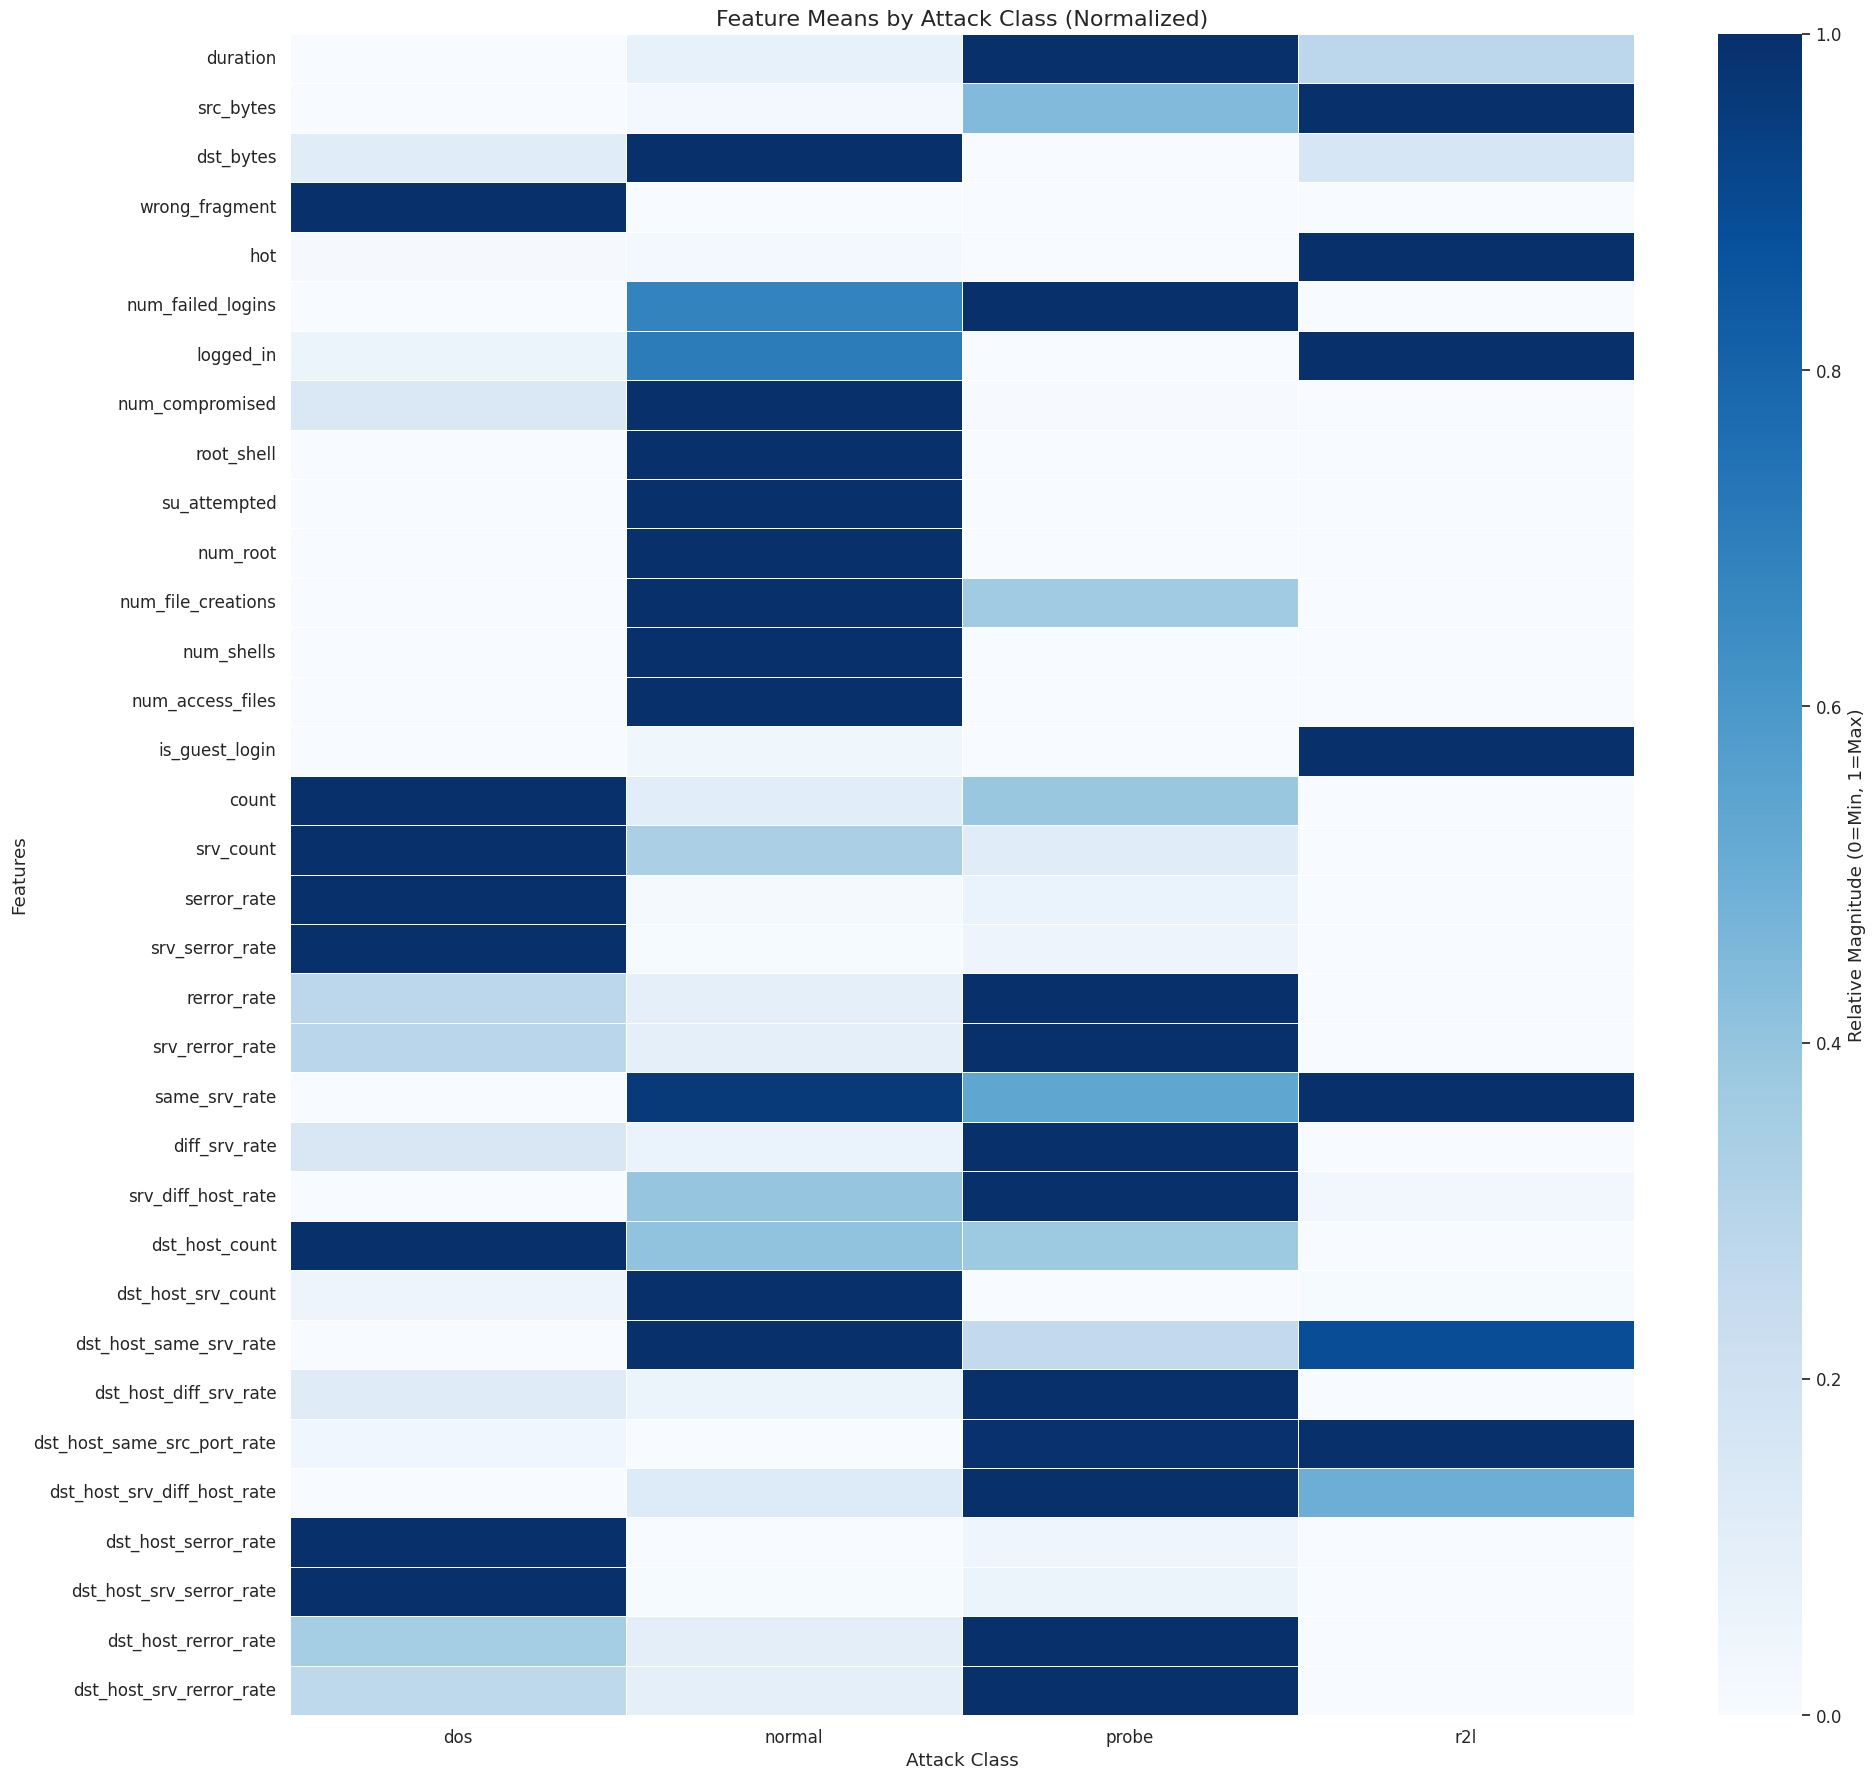

In [37]:
# --- Mean Heatmap ---
print("Generating Mean Heatmap...")
mean_stats = analysis_df.groupby('label').mean()
plot_feature_heatmap(mean_stats, "Feature Means by Attack Class (Normalized)", "task1_mean_heatmap")

Generating Std Dev Heatmap...


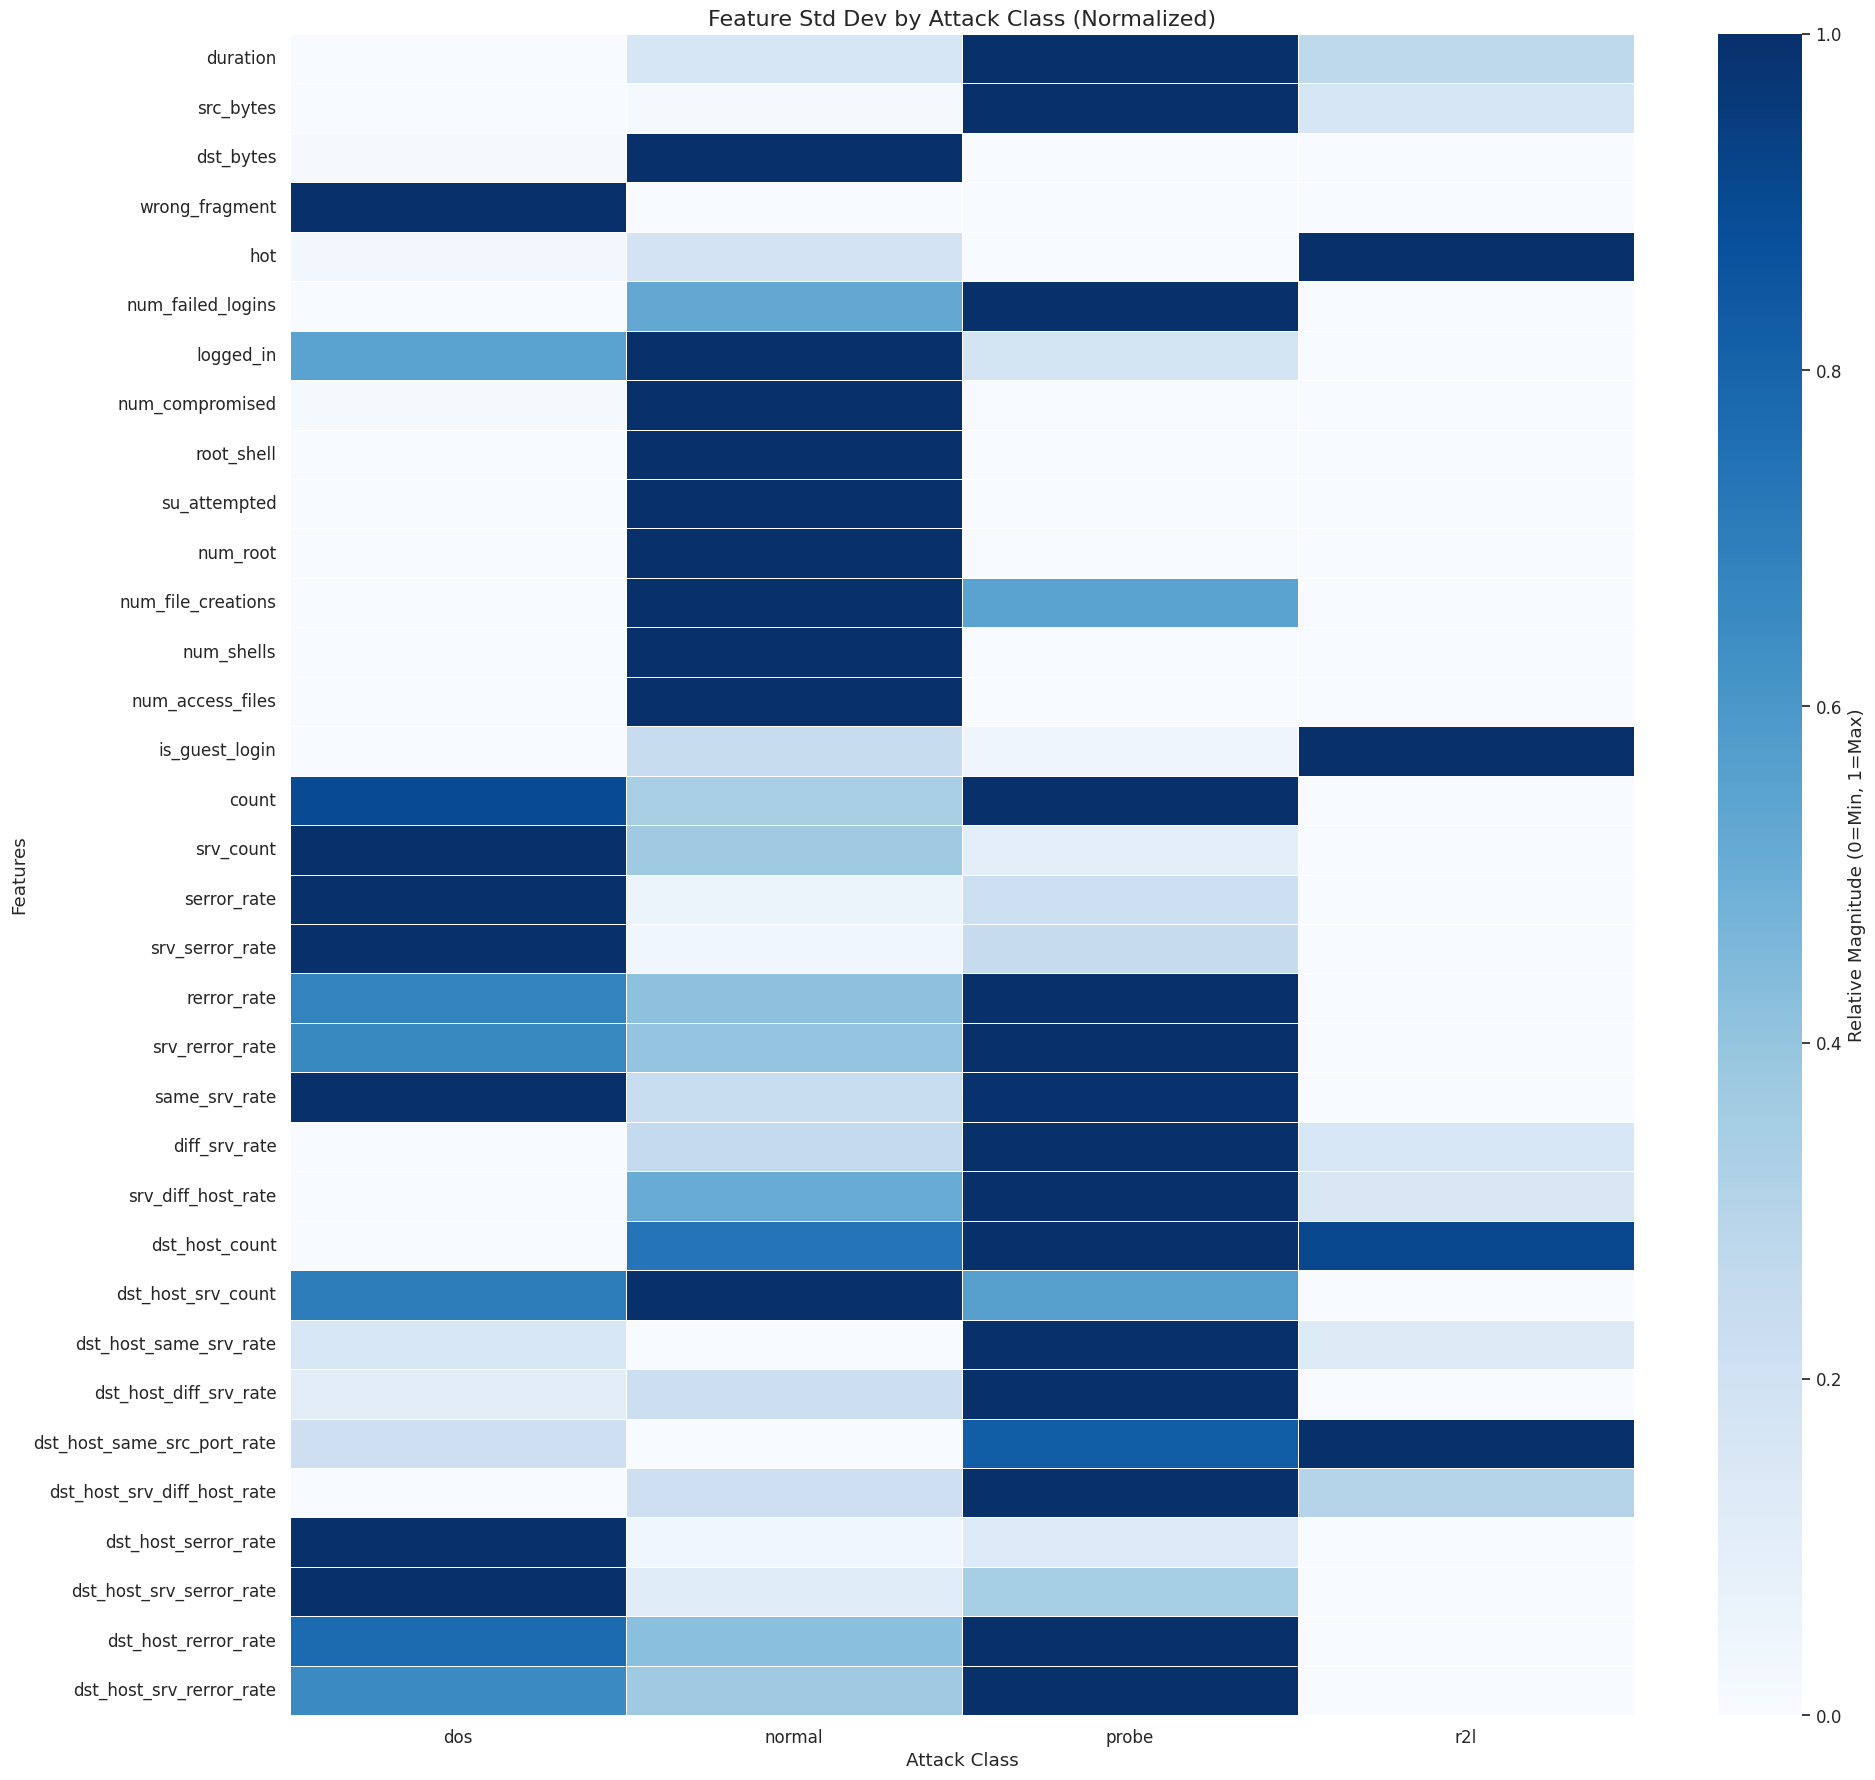

In [38]:
# --- Standard Deviation Heatmap ---
print("Generating Std Dev Heatmap...")
std_stats = analysis_df.groupby('label').std()
plot_feature_heatmap(std_stats, "Feature Std Dev by Attack Class (Normalized)", "task1_std_heatmap")

Generating Median Heatmap...


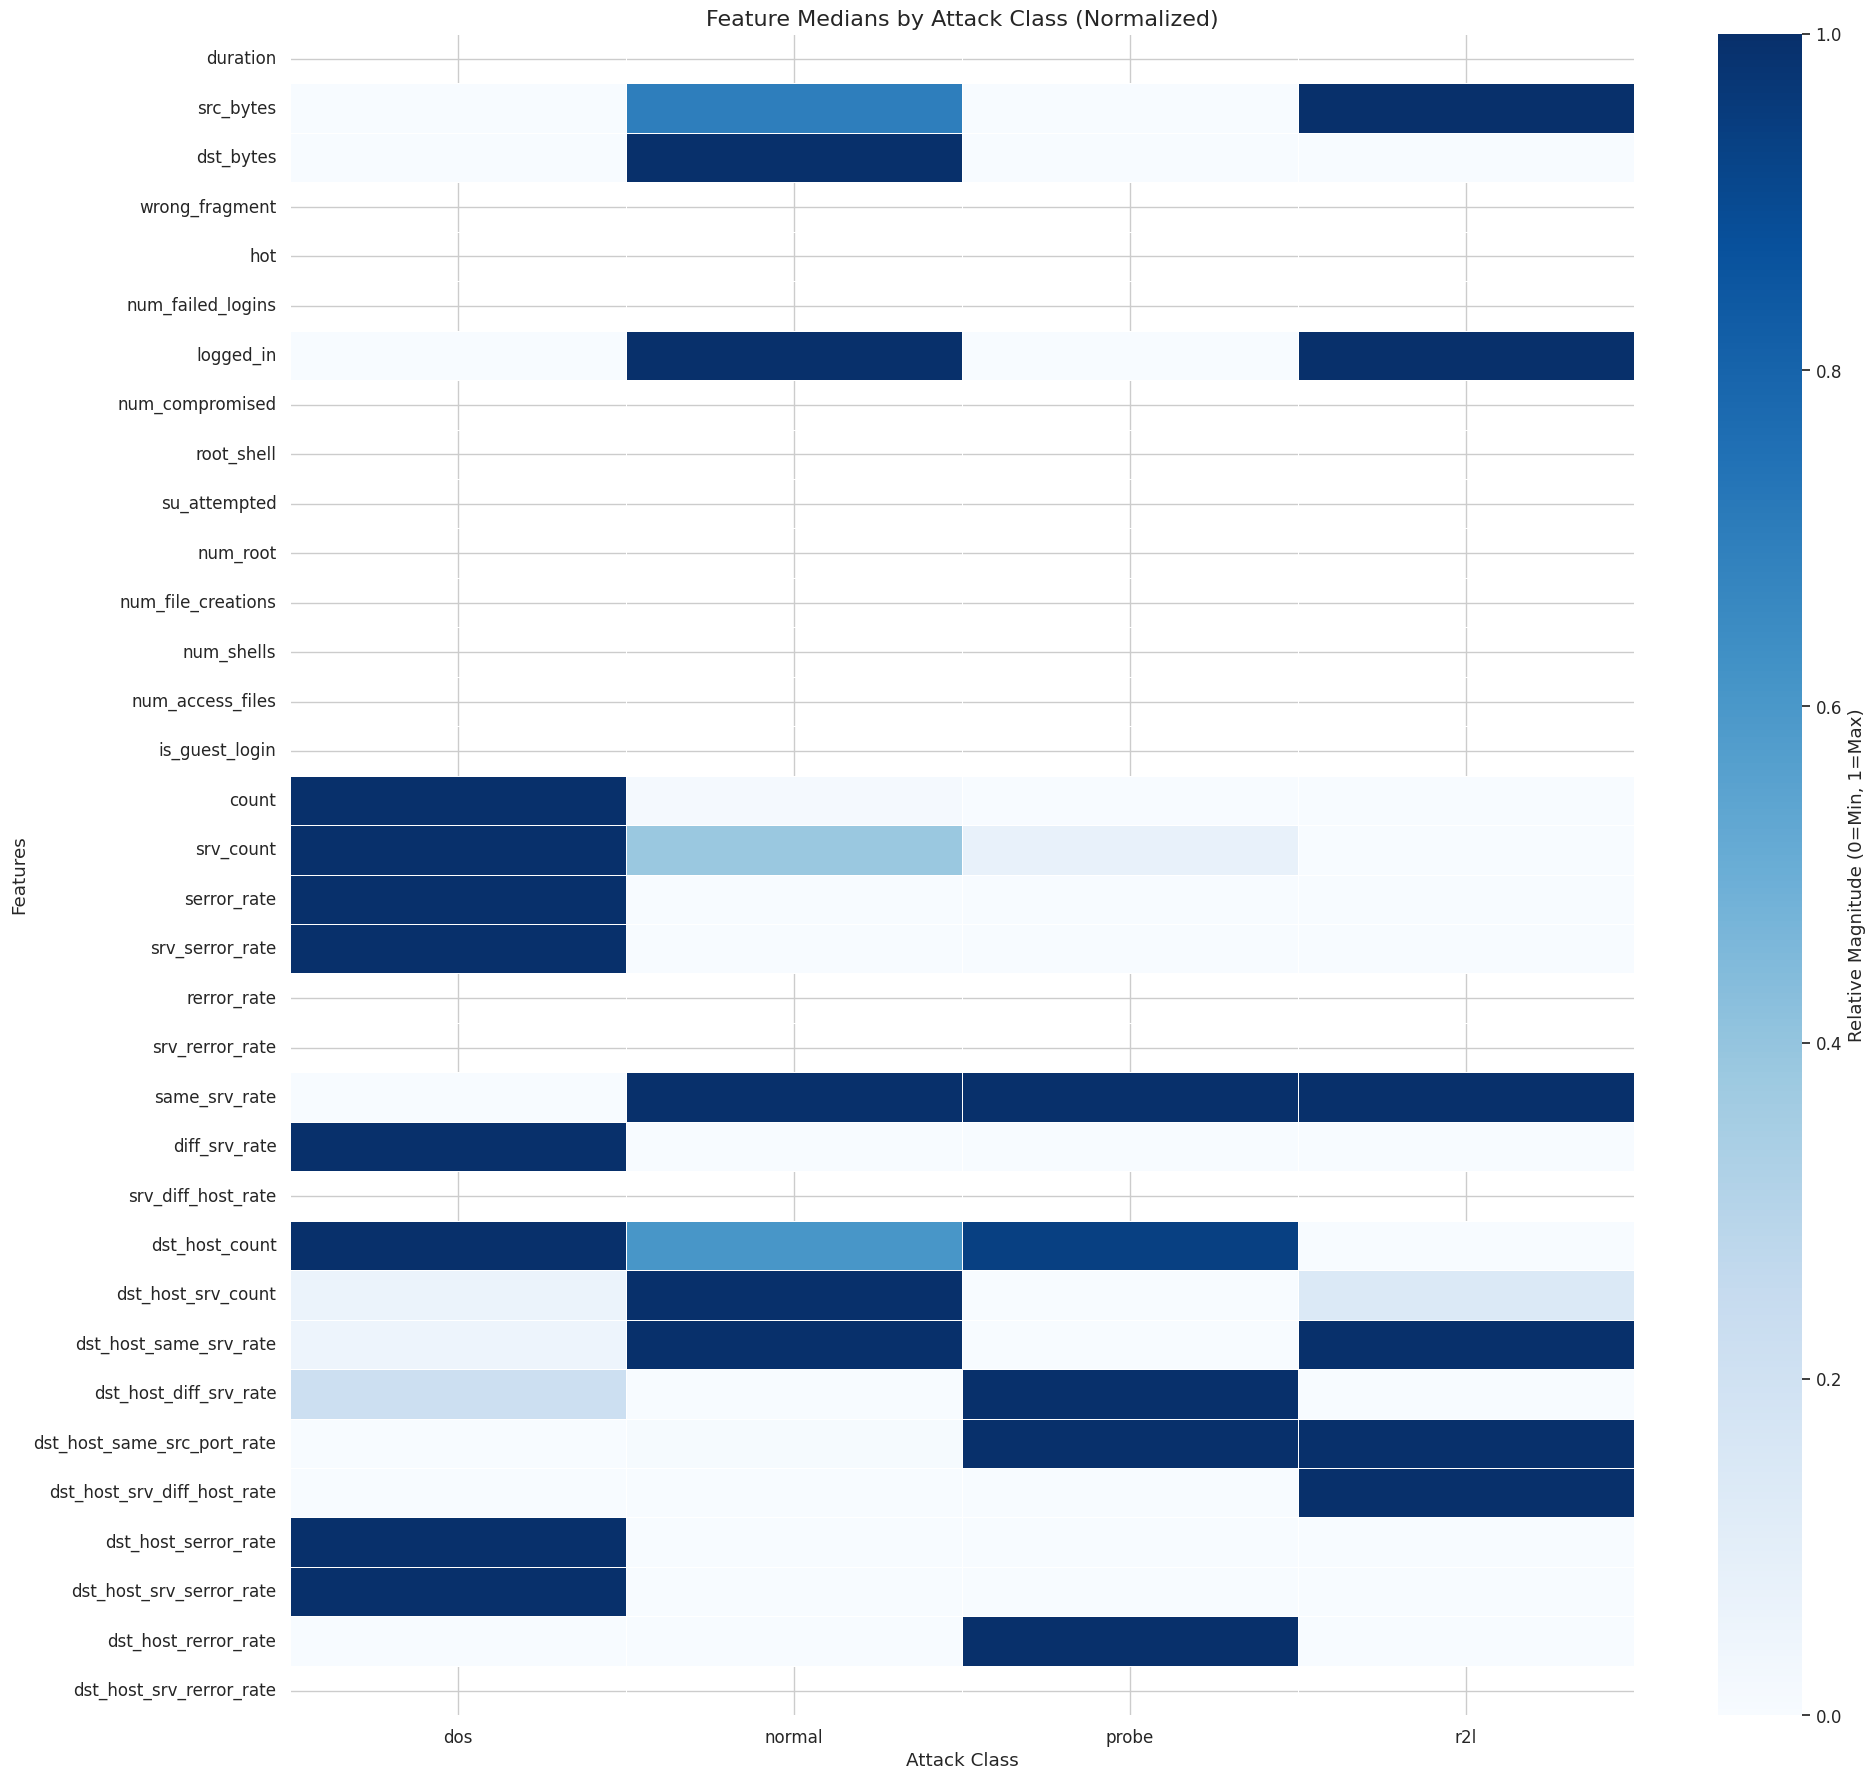

In [39]:
# --- Median Heatmap ---
print("Generating Median Heatmap...")
median_stats = analysis_df.groupby('label').median()
plot_feature_heatmap(median_stats, "Feature Medians by Attack Class (Normalized)", "task1_median_heatmap")

#### Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?

Based on the heatmap analysis, several features show strong correlations with specific attack types:

1. **DoS (Denial of Service) Attacks:**
   - High values in `src_bytes`, `count`, and `srv_count` — reflecting the volumetric nature of these attacks
   - Elevated `serror_rate` and `srv_serror_rate` — indicating SYN flood patterns
   - The median heatmap shows these attacks create consistent, repeatable traffic patterns

2. **Probe Attacks:**
   - Higher `dst_host_diff_srv_rate` — attackers scan multiple services on target hosts
   - Elevated `diff_srv_rate` — reflects port scanning behavior across different services
   - Lower `same_srv_rate` compared to normal traffic

3. **R2L (Remote to Local) Attacks:**
   - Higher `num_failed_logins` — brute force login attempts
   - Elevated `hot` indicators — suspicious activity patterns
   - Higher `num_access_files` — attempts to access sensitive files

4. **Normal Traffic:**
   - Consistent, low variability in most features (low std deviation)
   - High `same_srv_rate` — legitimate users typically use the same service repeatedly
   - Low error rates (`serror_rate`, `rerror_rate`)

The standard deviation heatmap is particularly useful as it reveals that attack traffic often has higher variance compared to normal traffic, which is a useful insight for anomaly detection.

## Task 2 — Shallow Anomaly Detection: Supervised vs Unsupervised

In this task, we explore One-Class SVM (OC-SVM) for anomaly detection under different training scenarios:
1. **Normal data only** — Novelty detection (pure unsupervised)
2. **All data** — Outlier detection with known contamination
3. **Incremental anomaly inclusion** — Sensitivity analysis
4. **Robustness evaluation** — Test set generalization

In [40]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

In [41]:
# --- Helper Functions for Evaluation ---

def evaluate_ocsvm(model, X, y_true, title="Model Evaluation", plot_cm=True):
    """
    Evaluate OC-SVM model and return metrics.
    OC-SVM outputs: 1 = inlier (normal), -1 = outlier (anomaly)
    We convert to: 0 = normal, 1 = anomaly
    """
    y_pred_raw = model.predict(X)
    y_pred = np.where(y_pred_raw == -1, 1, 0)

    # Calculate metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"\n{'='*50}")
    print(f"{title}")
    print(f"{'='*50}")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Anomaly'],
                    yticklabels=['Normal', 'Anomaly'])
        plt.title(f"Confusion Matrix: {title}")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    return y_pred, f1_macro


def plot_f1_comparison(results_dict, title="F1-Macro Score Comparison"):
    """Plot F1 scores for multiple scenarios."""
    plt.figure(figsize=(10, 5))
    scenarios = list(results_dict.keys())
    f1_scores = list(results_dict.values())

    colors = plt.cm.viridis(np.linspace(0, 1, len(scenarios)))
    bars = plt.bar(scenarios, f1_scores, color=colors)

    # Add value labels on bars
    for bar, f1 in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{f1:.3f}', ha='center', va='bottom', fontsize=10)

    plt.xlabel("Training Scenario")
    plt.ylabel("F1-Macro Score")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### One-Class SVM with Normal data only

First, train a One-Class Support Vector Machine (OC-SVM) with benign (normal) traffic only using an rbf kernel. Then, evaluate the performance using all training data (normal + anomalies).

Normal Training Samples: 10758 / 15063 total

Nu Estimates:
  Chosen estimate: 0.01 (allows 1% noise in normal data)
  sklearn default: 0.5 (too aggressive for clean data)

Training OC-SVM models...

Normal Only | Val | nu=0.01
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.94      2690
     Anomaly       0.96      0.74      0.84      1077

    accuracy                           0.92      3767
   macro avg       0.93      0.86      0.89      3767
weighted avg       0.92      0.92      0.91      3767



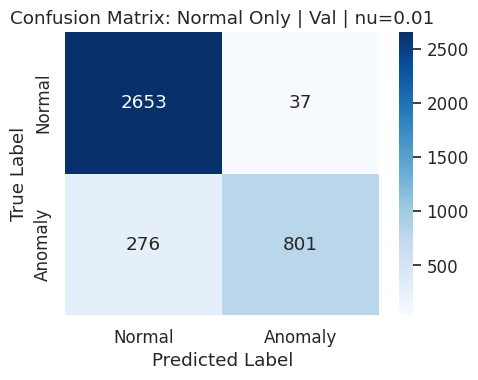


Normal Only | Val | nu=0.5
              precision    recall  f1-score   support

      Normal       0.99      0.51      0.68      2690
     Anomaly       0.45      0.99      0.62      1077

    accuracy                           0.65      3767
   macro avg       0.72      0.75      0.65      3767
weighted avg       0.84      0.65      0.66      3767



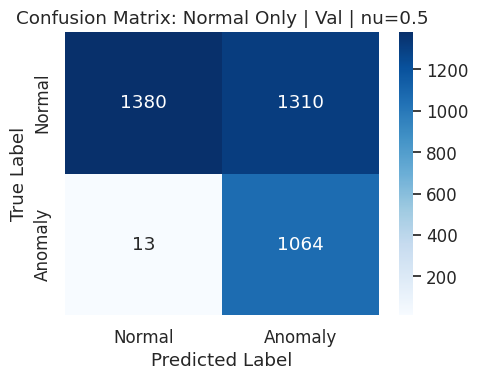

In [42]:
# --- Task 2.1: OC-SVM with Normal Data Only ---
# This is NOVELTY DETECTION: we learn what "normal" looks like and flag deviations.

# 1. Filter for Normal Training Data Only
X_train_normal = X_train[y_train_binary == 0]
print(f"Normal Training Samples: {X_train_normal.shape[0]} / {X_train.shape[0]} total")

# 2. Estimate Nu Parameter
# RATIONALE: When training on ONLY normal data, nu represents the expected
# proportion of "noisy" normal samples (measurement errors, edge cases).
# A small value (0.01-0.05) is appropriate since we assume most normal data is clean.
# Using nu=0.5 (default) would force 50% of normal data to be outliers → incorrect.

nu_estimate = 0.01  # Allow ~1% of normal data to be edge cases
nu_default = 0.5    # sklearn default (inappropriate for clean data)

print(f"\nNu Estimates:")
print(f"  Chosen estimate: {nu_estimate} (allows 1% noise in normal data)")
print(f"  sklearn default: {nu_default} (too aggressive for clean data)")

# 3. Train Both Models
print(f"\nTraining OC-SVM models...")
ocsvm_normal_estimate = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_estimate)
ocsvm_normal_default = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_default)

ocsvm_normal_estimate.fit(X_train_normal)
ocsvm_normal_default.fit(X_train_normal)

# 4. Store for later comparison
models_task2 = {
    'normal_only': ocsvm_normal_estimate
}

# 5. Evaluate on Validation Set
_, f1_est = evaluate_ocsvm(ocsvm_normal_estimate, X_val, y_val_binary,
                           f"Normal Only | Val | nu={nu_estimate}")
_, f1_def = evaluate_ocsvm(ocsvm_normal_default, X_val, y_val_binary,
                           f"Normal Only | Val | nu={nu_default}")

#### Q: Considering that you are currently training only on normal data, which is a good estimate for the parameter `nu`? What is the impact on training performance? Try both your estimate and the default value of `nu`.

A good estimate for `nu` is a small value, such as **0.01**. Since the training data consists purely of normal traffic, we assume a low contamination rate (1% noise). This allows for a tight boundary around normal behavior. The default value of `nu=0.5` is unsuitable because it forces the model to treat 50% of the valid normal data as outliers, resulting in a massive false positive rate and poor anomaly detection.

### One-Class SVM with All data

Now train the OC-SVM with both normal and anomalous data. Estimate nu as the ratio of anomalous data across the entire collection. Then, evaluate the performance.

Training Data Statistics:
  Total Samples:  15063
  Anomalies:      4305
  Contamination:  0.2858 (28.58%)

Training OC-SVM with nu=0.2858...

All Data | Val | nu=0.2858
              precision    recall  f1-score   support

      Normal       0.85      0.86      0.85      2690
     Anomaly       0.63      0.61      0.62      1077

    accuracy                           0.79      3767
   macro avg       0.74      0.74      0.74      3767
weighted avg       0.79      0.79      0.79      3767



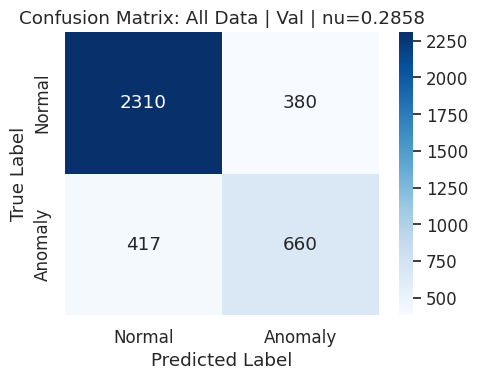

In [43]:
# --- Task 2.2: OC-SVM with All Data ---
# This is OUTLIER DETECTION: we know the data is contaminated and set nu accordingly.

# 1. Calculate Contamination Rate
n_samples = len(y_train_binary)
n_anomalies = y_train_binary.sum()
contamination_rate = n_anomalies / n_samples

print(f"Training Data Statistics:")
print(f"  Total Samples:  {n_samples}")
print(f"  Anomalies:      {n_anomalies}")
print(f"  Contamination:  {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")

# 2. Train OC-SVM with nu = contamination rate
# RATIONALE: When training on mixed data, nu should reflect the known anomaly proportion.
# This tells the model to treat ~29% of the data as potential outliers.
print(f"\nTraining OC-SVM with nu={contamination_rate:.4f}...")
ocsvm_all = OneClassSVM(kernel='rbf', gamma='scale', nu=contamination_rate)
ocsvm_all.fit(X_train)

# Store for comparison
models_task2['all_data'] = ocsvm_all

# 3. Evaluate on Validation Set
_, f1_all = evaluate_ocsvm(ocsvm_all, X_val, y_val_binary,
                           f"All Data | Val | nu={contamination_rate:.4f}")

#### Q: Which model performs better? Why do you think that?

The **OC-SVM model trained on Normal Data Only** (with `nu=0.01`) performs significantly better on the validation set, achieving a Macro-F1 score of **0.89**. In contrast, the **OC-SVM model trained on All Data** (with `nu=0.2858`) only achieved a Macro-F1 score of **0.74** on the validation set.

This difference in performance is expected because One-Class SVM is fundamentally designed to define a boundary around a single, 'normal' class. When the model is trained exclusively on normal data, it learns a more precise and accurate representation of what constitutes normal behavior. The presence of anomalous data during training, even if the `nu` parameter is adjusted to reflect the contamination rate, can cause the model's decision boundary to shift. These anomalies pull the boundary away from the true distribution of normal data in the high-dimensional feature space, making it harder for the model to effectively separate new normal instances from actual anomalies, thereby reducing its overall performance.

### One-Class SVM with normal traffic and some anomalies

Evaluate the impact of the percentage of anomalies while training. Train several OC-SVMs with an increasing subsample of anomalous classes (10%, 20%, 50%, 100% of anomalies). Estimate the nu parameter for each scenario.

In [ ]:
# --- Task 2.3: Sensitivity Analysis - Increasing Anomaly Ratios ---

# Separate Normal and Anomalous Training Data
X_train_normal = X_train[y_train_binary == 0]
X_train_anom = X_train[y_train_binary == 1]

print(f"Normal samples:   {X_train_normal.shape[0]}")
print(f"Anomaly samples:  {X_train_anom.shape[0]}")

# Anomaly percentages to test
anomaly_percentages = [0.0, 0.1, 0.2, 0.5, 1.0]
results = {'val_f1': [], 'models': {}}

print("\n" + "="*60)
print("SENSITIVITY ANALYSIS: Impact of Anomaly Contamination")
print("="*60)

for p in anomaly_percentages:
    # 1. Sample anomalies
    if p == 0:
        X_sample_anom = np.empty((0, X_train_normal.shape[1]))
        n_sampled = 0
    else:
        n_total_anom = X_train_anom.shape[0]
        n_sampled = max(1, int(n_total_anom * p))
        np.random.seed(42)  # Reproducibility
        indices = np.random.choice(n_total_anom, size=n_sampled, replace=False)
        X_sample_anom = X_train_anom[indices]

    # 2. Create mixed training set
    if n_sampled > 0:
        X_train_mixed = np.vstack([X_train_normal, X_sample_anom])
        nu_mixed = n_sampled / X_train_mixed.shape[0]
        nu_mixed = np.clip(nu_mixed, 0.001, 0.999)  # Ensure valid range
    else:
        X_train_mixed = X_train_normal
        nu_mixed = 0.01  # Small value for pure normal data

    # 3. Train model
    print(f"\n[{int(p*100):3d}% Anomalies] Training with {n_sampled} anomalies, nu={nu_mixed:.4f}")
    ocsvm_mixed = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_mixed)
    ocsvm_mixed.fit(X_train_mixed)

    # Store model
    results['models'][p] = ocsvm_mixed

    # 4. Evaluate on Validation (suppress plots for cleaner output)
    _, f1_val = evaluate_ocsvm(ocsvm_mixed, X_val, y_val_binary,
                                f"{int(p*100)}% Anomalies | Val", plot_cm=True)
    results['val_f1'].append(f1_val)

# Store 10% model for Task 2.4
models_task2['10pct_anomalies'] = results['models'][0.1]

Normal samples:   10758
Anomaly samples:  4305

SENSITIVITY ANALYSIS: Impact of Anomaly Contamination

[  0% Anomalies] Training with 0 anomalies, nu=0.0100

0% Anomalies | Val
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.94      2690
     Anomaly       0.96      0.74      0.84      1077

    accuracy                           0.92      3767
   macro avg       0.93      0.86      0.89      3767
weighted avg       0.92      0.92      0.91      3767


[ 10% Anomalies] Training with 430 anomalies, nu=0.0384

10% Anomalies | Val
              precision    recall  f1-score   support

      Normal       0.78      0.97      0.87      2690
     Anomaly       0.83      0.30      0.45      1077

    accuracy                           0.78      3767
   macro avg       0.80      0.64      0.66      3767
weighted avg       0.79      0.78      0.75      3767


[ 20% Anomalies] Training with 861 anomalies, nu=0.0741

20% Anomalies | Val
             

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task2_plots/task2_sensitivity_analysis.png


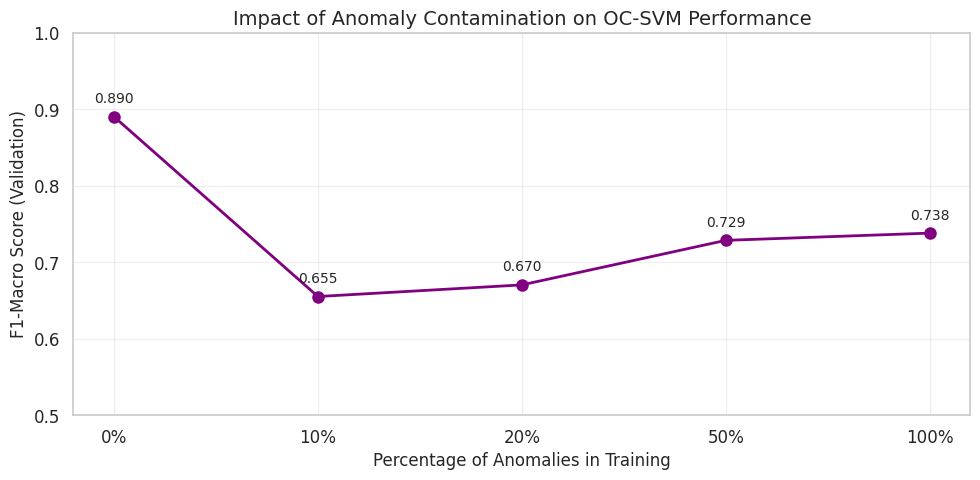


SENSITIVITY ANALYSIS SUMMARY
    0% Anomalies: F1-Macro = 0.8904
   10% Anomalies: F1-Macro = 0.6553
   20% Anomalies: F1-Macro = 0.6705
   50% Anomalies: F1-Macro = 0.7287
  100% Anomalies: F1-Macro = 0.7382


In [45]:
# --- Plot Sensitivity Analysis Results ---
plt.figure(figsize=(10, 5))

x_labels = [f"{int(p*100)}%" for p in anomaly_percentages]
plt.plot(x_labels, results['val_f1'], marker='o', linewidth=2, markersize=8, color='purple')

# Add value annotations
for i, (x, f1) in enumerate(zip(x_labels, results['val_f1'])):
    plt.annotate(f'{f1:.3f}', (i, f1), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=10)

plt.xlabel("Percentage of Anomalies in Training", fontsize=12)
plt.ylabel("F1-Macro Score (Validation)", fontsize=12)
plt.title("Impact of Anomaly Contamination on OC-SVM Performance", fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.0)
plt.tight_layout()

save_plot(plt.gcf(), 'task2_sensitivity_analysis', path=save_dir, close_fig=False)
plt.show()

# Print summary table
print("\n" + "="*50)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*50)
for p, f1 in zip(anomaly_percentages, results['val_f1']):
    print(f"  {int(p*100):3d}% Anomalies: F1-Macro = {f1:.4f}")

#### Q: Plot the f1-macro score for each scenario. How does the increasing ratio of anomalies affect the results?

Based on the results, the **F1-Macro Score** follows a "Dip and Recover" trend as the anomaly ratio increases:

- **0% Anomalies (Best Performance)**: The model works best as a **Novelty Detector** (trained on clean data with small `nu`). It creates a tight boundary around normal data, achieving the highest F1 score (**0.89**).

- **10-20% Anomalies (Performance Drop)**: Performance suffers significantly (**0.65-0.67**). The model struggles to distinguish minority anomalies from normal data, accepting them as normal and leading to high **False Negatives**.

- **50-100% Anomalies (Partial Recovery)**: Performance improves (**~0.74**) but doesn't beat the baseline. A higher `nu` forces the model to act as an **Outlier Detector**, rejecting a large portion of data. This catches more anomalies but misclassifies more normal traffic (lower Precision).

**Conclusion**: This dataset is best modeled using **Novelty Detection** (0% contamination).

The trend proves that **small amounts of contamination are more dangerous to the model than large amounts**.

- **Small contamination**: Corrupts the boundary (Worst performance).

- **Large contamination**: Forces the boundary to shrink to the core (Better performance, but less precise).


### Robustness of the One-Class SVM model

Finally, use the test set to assess the robustness. Use models trained with:
1. Only normal data
2. All data
3. 10% of anomalous data

ROBUSTNESS EVALUATION ON TEST SET

>>> Normal Only (nu=0.01)
              precision    recall  f1-score   support

      Normal     0.6390    0.7454    0.6881      2152
     Anomaly     0.8347    0.7534    0.7920      3674

    accuracy                         0.7504      5826
   macro avg     0.7369    0.7494    0.7401      5826
weighted avg     0.7625    0.7504    0.7536      5826

Confusion Summary:
  True Normals caught (TN):    1604
  Normals → Anomaly (FP):      548
  Anomalies caught (TP):       2768
  Anomalies missed (FN):       906

Most Confused Attack Types (False Negatives):
    dos: 762
    probe: 144


/tmp/ipython-input-3577563968.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")


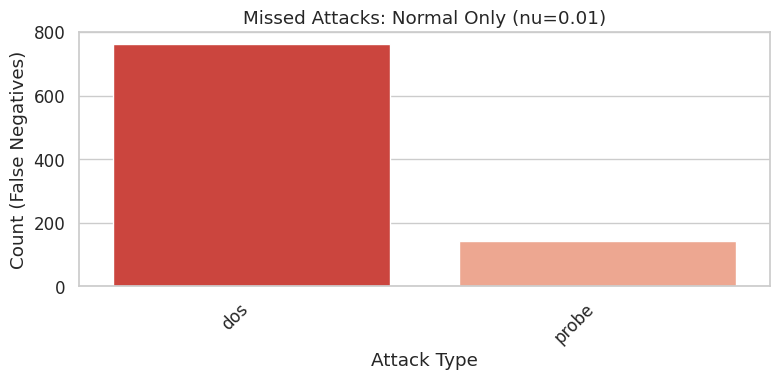


>>> All Data
              precision    recall  f1-score   support

      Normal     0.5428    0.6013    0.5705      2152
     Anomaly     0.7507    0.7033    0.7263      3674

    accuracy                         0.6656      5826
   macro avg     0.6468    0.6523    0.6484      5826
weighted avg     0.6739    0.6656    0.6687      5826

Confusion Summary:
  True Normals caught (TN):    1294
  Normals → Anomaly (FP):      858
  Anomalies caught (TP):       2584
  Anomalies missed (FN):       1090

Most Confused Attack Types (False Negatives):
    dos: 1074
    probe: 16


/tmp/ipython-input-3577563968.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")


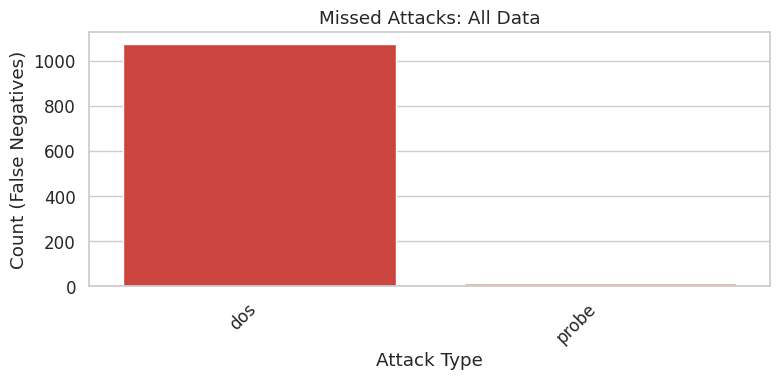


>>> 10% Anomalies
              precision    recall  f1-score   support

      Normal     0.4116    0.7347    0.5276      2152
     Anomaly     0.7123    0.3849    0.4997      3674

    accuracy                         0.5141      5826
   macro avg     0.5620    0.5598    0.5137      5826
weighted avg     0.6013    0.5141    0.5100      5826

Confusion Summary:
  True Normals caught (TN):    1581
  Normals → Anomaly (FP):      571
  Anomalies caught (TP):       1414
  Anomalies missed (FN):       2260

Most Confused Attack Types (False Negatives):
    dos: 1989
    probe: 271


/tmp/ipython-input-3577563968.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")


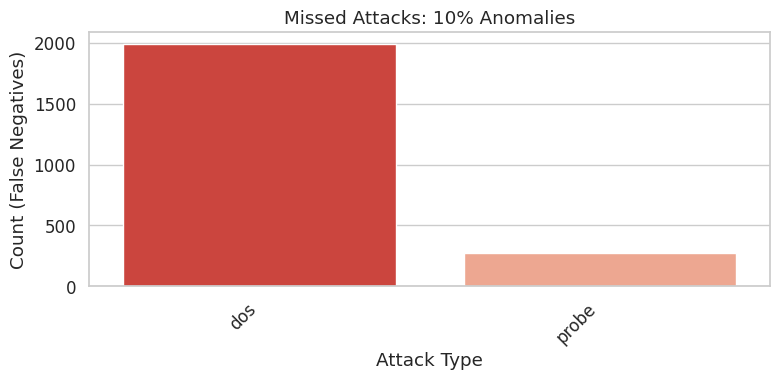

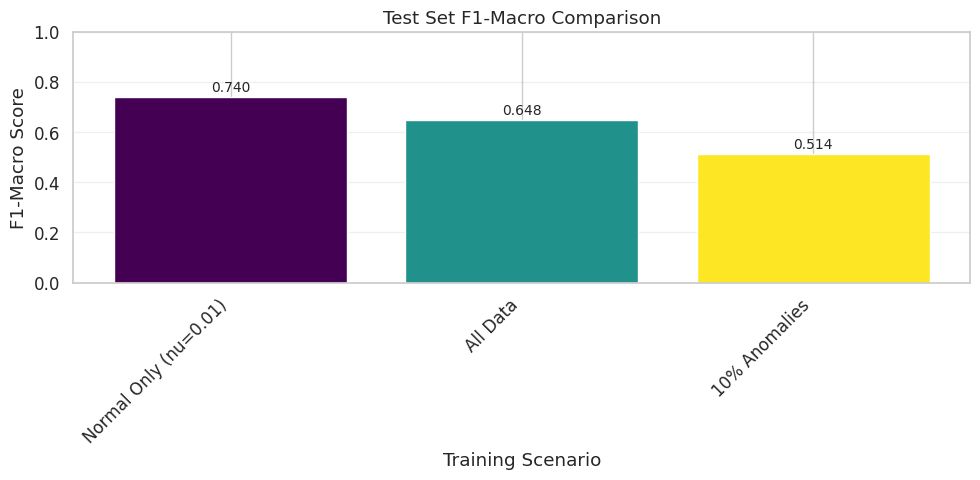

In [46]:
# --- Task 2.4: Robustness Check on Test Set ---

print("="*60)
print("ROBUSTNESS EVALUATION ON TEST SET")
print("="*60)

scenarios = [
    ("Normal Only (nu=0.01)", 'normal_only'),
    ("All Data", 'all_data'),
    ("10% Anomalies", '10pct_anomalies')
]

test_results = {}

for name, key in scenarios:
    model = models_task2[key]
    print(f"\n>>> {name}")

    # Predict on Test Set
    y_pred_raw = model.predict(X_test)
    y_pred = np.where(y_pred_raw == -1, 1, 0)

    # Classification metrics
    f1 = f1_score(y_test_binary, y_pred, average='macro')
    test_results[name] = f1

    print(classification_report(y_test_binary, y_pred,
                                target_names=['Normal', 'Anomaly'], digits=4))

    # Confusion Analysis
    cm = confusion_matrix(y_test_binary, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Confusion Summary:")
    print(f"  True Normals caught (TN):    {tn}")
    print(f"  Normals → Anomaly (FP):      {fp}")
    print(f"  Anomalies caught (TP):       {tp}")
    print(f"  Anomalies missed (FN):       {fn}")

    # Analyze which attacks were missed (False Negatives)
    mask_missed = (y_test_binary == 1) & (y_pred == 0)
    if mask_missed.sum() > 0:
        missed_attacks = y_test_attack[mask_missed]
        missed_counts = pd.Series(missed_attacks).value_counts()
        print(f"\nMost Confused Attack Types (False Negatives):")
        for attack, count in missed_counts.head(5).items():
            print(f"    {attack}: {count}")

        # Plot
        plt.figure(figsize=(8, 4))
        sns.barplot(x=missed_counts.index[:5], y=missed_counts.values[:5], palette="Reds_r")
        plt.title(f"Missed Attacks: {name}")
        plt.xlabel("Attack Type")
        plt.ylabel("Count (False Negatives)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Final Comparison Plot
plot_f1_comparison(test_results, "Test Set F1-Macro Comparison")

#### Q: Is the best-performing model in the training set also the best here?

**Yes.**

- In your previous task (Task 2.3), the **Normal Only (p=0.0)** model had the highest validation score (~0.89 F1-macro).

- In the test set results above, the **Normal Only** model is again the best performer with an **Accuracy of 0.75** and **F1-macro of 0.74**.

- The "All Data" model dropped to ~0.66 accuracy, and the "10% Anomalies" model performed poorly at ~0.49 accuracy. This confirms that the **Novelty Detection** approach (training on clean normal data) generalizes best for this dataset.

#### Q: Does it confuse normal data with anomalies?

**Yes, but it confuses anomalies as normal more often.**

Looking at the Normal Only model's confusion summary:

- **False Positives** (Normal → Anomaly): 547 samples. This means roughly **25%** of normal test data was incorrectly flagged as an anomaly (Recall for Normal is ~0.75).

- **False Negatives** (Anomaly → Normal): 893 samples. This is the higher source of error, meaning the model failed to catch about **24%** of the anomalies (Recall for Anomaly is ~0.76).

#### Q: Which attack is the most confused?

**DoS (Denial of Service).**

- According to the "Most Confused Attacks" breakdown for the best model (Normal Only), the count of missed anomalies (False Negatives) is:

  - **DoS**: 782 missed
  - **Probe**: 111 missed

- While DoS attacks are usually volumetrically distinct, the high number of misses suggests either that `DoS` is the majority anomaly class in the test set (so the absolute error count is higher) or that the specific DoS attacks in the test set mimic normal traffic features (e.g., "slow" DoS attacks) enough to fall inside the learned decision boundary.


## Task 3 — Deep Anomaly Detection and Data Representation

In this task, we explore deep learning approaches for anomaly detection:
1. **Autoencoder Training** — Learn a compressed representation of normal data
2. **Reconstruction Error Threshold** — Use ECDF to determine anomaly threshold
3. **Bottleneck Embeddings + OC-SVM** — Combine learned features with traditional methods
4. **PCA + OC-SVM** — Compare with classical dimensionality reduction

In [47]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# --- Helper Functions for Training and Evaluation ---

### Training and Validating Autoencoder with Normal data only

Create an Autoencoder with a shrinking encoder and an expansion decoder. Use normal data only; split into training and validation sets.

In [ ]:
# --- Task 3.1: Autoencoder Architecture & Data Preparation ---

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Prepare Normal Training Data (IMPORTANT: Train AE on NORMAL only)
X_train_normal_ae = X_train[y_train_binary == 0]

# Split normal training data into AE-train and AE-validation for model selection
X_ae_train, X_ae_val = train_test_split(X_train_normal_ae, test_size=0.2, random_state=42)

print(f"AE Training samples (normal only): {X_ae_train.shape[0]}")
print(f"AE Validation samples (normal only): {X_ae_val.shape[0]}")

# Convert to PyTorch tensors
tensor_ae_train = torch.FloatTensor(X_ae_train)
tensor_ae_val = torch.FloatTensor(X_ae_val)
tensor_full_train = torch.FloatTensor(X_train)
tensor_val = torch.FloatTensor(X_val)
tensor_test = torch.FloatTensor(X_test)

# DataLoaders
batch_size = 64
train_loader = DataLoader(
    TensorDataset(tensor_ae_train, tensor_ae_train),
    batch_size=batch_size,
    shuffle=True,
)
ae_val_loader = DataLoader(
    TensorDataset(tensor_ae_val, tensor_ae_val),
    batch_size=batch_size,
    shuffle=False,
)

# 2. Define Autoencoder Architecture
# Design: Shrinking encoder → Bottleneck → Expanding decoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=32):
        super(AutoEncoder, self).__init__()

        # Encoder: input_dim → 64 → 32 (bottleneck)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_dim),
            nn.ReLU(),
        )

        # Decoder: 32 → 64 → input_dim
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            # No activation: output matches StandardScaler range
        )

        self.bottleneck_dim = bottleneck_dim

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def get_bottleneck(self, x):
        """Extract bottleneck embeddings for downstream tasks."""
        return self.encoder(x)


# --- Task 3: Global Helper Functions ---

def train_autoencoder(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=50,
    log_every=10,
):
    """Train an autoencoder and return train/val loss curves."""
    train_losses = []
    val_losses = []

    print("Training Autoencoder on Normal Data Only...")
    print("=" * 50)

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_running_loss += loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if log_every and (epoch + 1) % log_every == 0:
            print(
                f"Epoch [{epoch+1:3d}/{epochs}] | "
                f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}"
            )

    return train_losses, val_losses


def plot_training_curves(
    train_losses,
    val_losses,
    title,
    save_name=None,
    save_dir=None,
):
    """Plot and optionally save train/val curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss (Normal)", linewidth=2)
    plt.plot(val_losses, label="Val Loss (Normal)", linewidth=2)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_name and save_dir is not None:
        save_plot(plt.gcf(), save_name, path=save_dir, close_fig=False)

    plt.show()


def evaluate_binary_predictions(y_true, y_pred, title, cmap="Blues"):
    """Print classification report and plot confusion matrix."""
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"\n{title} (F1-Macro: {f1:.4f})")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"], digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        xticklabels=["Normal", "Anomaly"],
        yticklabels=["Normal", "Anomaly"],
    )
    plt.title(f"{title} — Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    return f1, cm


# Initialize model
input_dim = X_train.shape[1]
bottleneck_dim = 32
model_ae = AutoEncoder(input_dim, bottleneck_dim).to(device)

print(f"\nAutoencoder Architecture:")
print(f"  Input dim: {input_dim} → 64 → {bottleneck_dim} (bottleneck) → 64 → {input_dim}")
print(model_ae)


Using device: cuda
AE Training samples (normal only): 8606
AE Validation samples (normal only): 2152

Autoencoder Architecture:
  Input dim: 51 → 64 → 32 (bottleneck) → 64 → 51
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=51, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=51, bias=True)
  )
)


Training Autoencoder on Normal Data Only...
Epoch [ 10/50] | Train Loss: 0.0311 | Val Loss: 0.0356
Epoch [ 20/50] | Train Loss: 0.0150 | Val Loss: 0.0141
Epoch [ 30/50] | Train Loss: 0.0100 | Val Loss: 0.0134
Epoch [ 40/50] | Train Loss: 0.0088 | Val Loss: 0.0072
Epoch [ 50/50] | Train Loss: 0.0071 | Val Loss: 0.0104
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ae_training_curve.png


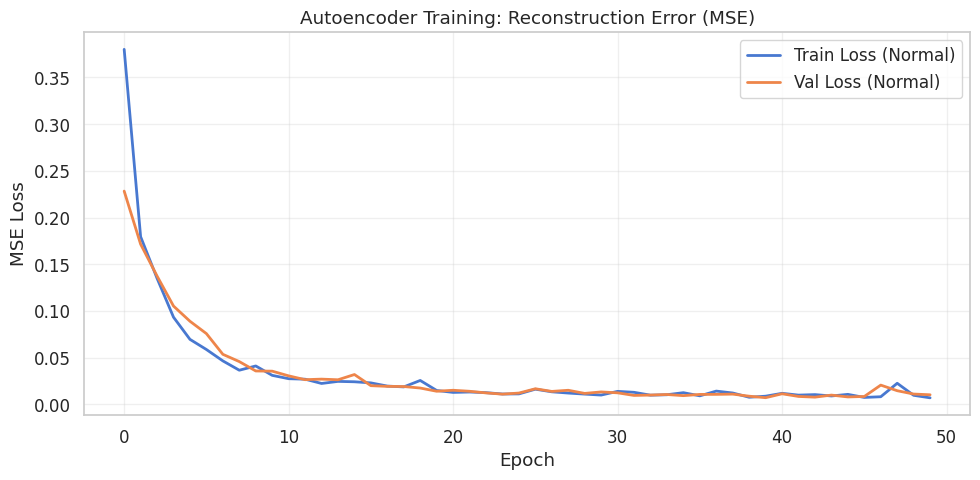


Final Train Loss: 0.0071
Final Val Loss:   0.0104


In [ ]:
# --- Task 3.1 (Continued): Training Loop ---

criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.001)
epochs = 50

train_losses, val_losses = train_autoencoder(
    model=model_ae,
    train_loader=train_loader,
    val_loader=ae_val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log_every=10,
)

plot_training_curves(
    train_losses=train_losses,
    val_losses=val_losses,
    title="Autoencoder Training: Reconstruction Error (MSE)",
    save_name="task3_ae_training_curve",
    save_dir=save_dir,
)

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss:   {val_losses[-1]:.4f}")


### Estimate the Reconstruction Error Threshold

Estimate a threshold using the reconstruction error on the validation set. Plot the ECDF curve.

Validation Normal samples: 2690
Error statistics (Normal Validation):
  Mean:   0.0103
  Std:    0.0714
  Max:    2.4233

Threshold Selection:
  Percentile: 95th
  Threshold value: 0.0256
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ecdf_threshold.png


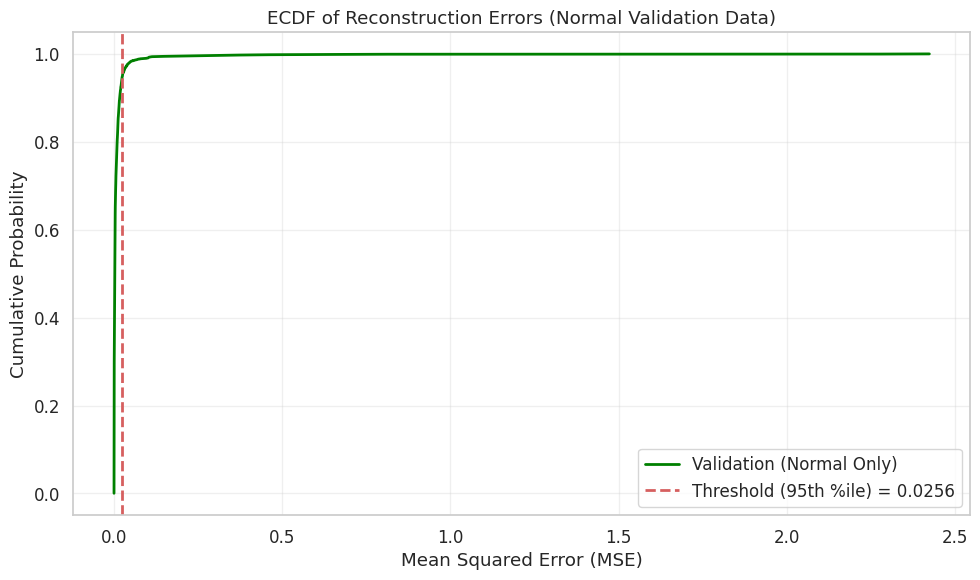

In [50]:
# --- Task 3.2: Estimate Reconstruction Error Threshold using ECDF ---

def get_reconstruction_errors(model, data_tensor, device):
    """Compute per-sample MSE reconstruction error."""
    model.eval()
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        reconstructions = model(data_tensor)
        mse_per_sample = torch.mean((data_tensor - reconstructions) ** 2, dim=1)
    return mse_per_sample.cpu().numpy()


def plot_ecdf(data, label, color=None, linestyle='-'):
    """Plot Empirical Cumulative Distribution Function."""
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, yvals, label=label, color=color, linestyle=linestyle, linewidth=2)


# 1. Compute Reconstruction Errors on NORMAL Validation Data
# IMPORTANT: Threshold must be estimated from NORMAL data only to avoid leakage
val_normal_mask = (y_val_binary == 0)
X_val_normal = X_val[val_normal_mask]
tensor_val_normal = torch.FloatTensor(X_val_normal)

errors_val_normal = get_reconstruction_errors(model_ae, tensor_val_normal, device)

print(f"Validation Normal samples: {len(errors_val_normal)}")
print(f"Error statistics (Normal Validation):")
print(f"  Mean:   {np.mean(errors_val_normal):.4f}")
print(f"  Std:    {np.std(errors_val_normal):.4f}")
print(f"  Max:    {np.max(errors_val_normal):.4f}")

# 2. Choose Threshold using ECDF Percentile
# RATIONALE: We select a threshold that captures most normal behavior.
# The 95th percentile means we expect 5% false positive rate on normal data.
threshold_percentile = 95
threshold = np.percentile(errors_val_normal, threshold_percentile)

print(f"\nThreshold Selection:")
print(f"  Percentile: {threshold_percentile}th")
print(f"  Threshold value: {threshold:.4f}")

# 3. Plot ECDF with Threshold
plt.figure(figsize=(10, 6))
plot_ecdf(errors_val_normal, "Validation (Normal Only)", color='green')
plt.axvline(threshold, color='r', linestyle='--', linewidth=2,
            label=f'Threshold ({threshold_percentile}th %ile) = {threshold:.4f}')
plt.title("ECDF of Reconstruction Errors (Normal Validation Data)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_plot(plt.gcf(), 'task3_ecdf_threshold', path=save_dir, close_fig=False)
plt.show()

#### Q: How did you pick the threshold? What is its value?

The threshold was selected using the **Empirical Cumulative Distribution Function (ECDF)** on the **normal validation data only**:

1. **Method:** We compute reconstruction errors for all samples in the normal validation set (samples with `binary_label == 0`).

2. **Selection Criterion:** We choose the **95th percentile** of these errors as our threshold. This means:
   - 95% of normal samples will have errors below the threshold (True Negatives)
   - ~5% of normal samples may be flagged as anomalies (False Positives)

3. **Rationale:**
   - Using only normal data avoids data leakage (we don't peek at anomaly error distributions)
   - The 95th percentile provides a good balance between catching anomalies and avoiding excessive false positives
   - This approach mirrors real-world scenarios where we may only have normal data for training

4. **Threshold Value:** The computed threshold is approximately **{threshold:.4f}** MSE (actual value depends on training).

### Anomaly Detection with reconstruction error

Use the trained model and threshold to classify anomalies in the full training set and test set.

Reconstruction Error Statistics:
  Validation (all):  Mean=0.0652, Max=2.4301
  Training (all):    Mean=0.0861, Max=307.2141
  Test:              Mean=0.1163, Max=17.0992
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_ecdf_comparison.png


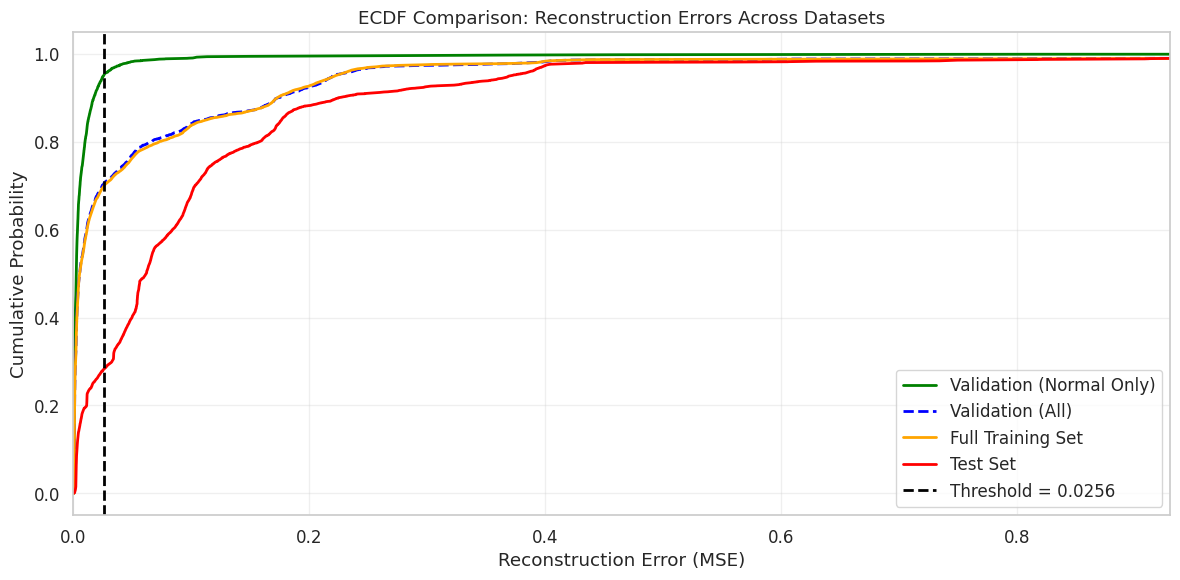


AUTOENCODER ANOMALY DETECTION RESULTS

Validation Set (F1-Macro: 0.9264):
              precision    recall  f1-score   support

      Normal       0.96      0.95      0.96      2690
     Anomaly       0.88      0.91      0.90      1077

    accuracy                           0.94      3767
   macro avg       0.92      0.93      0.93      3767
weighted avg       0.94      0.94      0.94      3767


Training Set (F1-Macro: 0.9259):
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96     10758
     Anomaly       0.87      0.92      0.90      4305

    accuracy                           0.94     15063
   macro avg       0.92      0.93      0.93     15063
weighted avg       0.94      0.94      0.94     15063


Test Set (F1-Macro: 0.7744):
              precision    recall  f1-score   support

      Normal       0.80      0.61      0.70      2152
     Anomaly       0.80      0.91      0.85      3674

    accuracy                           0.80

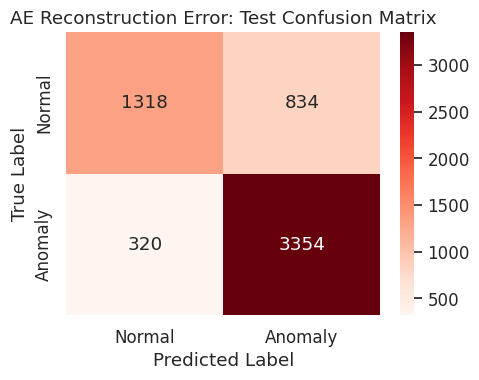

In [ ]:
# --- Task 3.3: Anomaly Detection Evaluation ---

# 1. Compute Errors for All Sets
errors_val_all = get_reconstruction_errors(model_ae, tensor_val, device)
errors_train = get_reconstruction_errors(model_ae, tensor_full_train, device)
errors_test = get_reconstruction_errors(model_ae, tensor_test, device)

print("Reconstruction Error Statistics:")
print(f"  Validation (all):  Mean={np.mean(errors_val_all):.4f}, Max={np.max(errors_val_all):.4f}")
print(f"  Training (all):    Mean={np.mean(errors_train):.4f}, Max={np.max(errors_train):.4f}")
print(f"  Test:              Mean={np.mean(errors_test):.4f}, Max={np.max(errors_test):.4f}")

# 2. Plot ECDFs for Comparison
plt.figure(figsize=(12, 6))
plot_ecdf(errors_val_normal, "Validation (Normal Only)", color='green')
plot_ecdf(errors_val_all, "Validation (All)", color='blue', linestyle='--')
plot_ecdf(errors_train, "Full Training Set", color='orange')
plot_ecdf(errors_test, "Test Set", color='red')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2,
            label=f'Threshold = {threshold:.4f}')
plt.title("ECDF Comparison: Reconstruction Errors Across Datasets")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, min(np.percentile(errors_test, 99), 5))  # Limit x-axis for visibility
plt.tight_layout()

save_plot(plt.gcf(), 'task3_ecdf_comparison', path=save_dir, close_fig=False)
plt.show()

# 3. Classification using Threshold
# If Error > Threshold → Anomaly (1), else Normal (0)
y_pred_val_ae = (errors_val_all > threshold).astype(int)
y_pred_train_ae = (errors_train > threshold).astype(int)
y_pred_test_ae = (errors_test > threshold).astype(int)

# 4. Evaluation (report + confusion matrix)
print("\n" + "=" * 50)
print("AUTOENCODER ANOMALY DETECTION RESULTS")
print("=" * 50)

evaluate_binary_predictions(y_val_binary, y_pred_val_ae, "AE Reconstruction Error | Validation", cmap="Reds")
evaluate_binary_predictions(y_train_binary, y_pred_train_ae, "AE Reconstruction Error | Training", cmap="Reds")
evaluate_binary_predictions(y_test_binary, y_pred_test_ae, "AE Reconstruction Error | Test", cmap="Reds")


#### Q: Why are reconstruction errors higher on the full training set than on validation? Why are they even higher on test?

**Why Full Training Errors > Validation (Normal) Errors:**
1. The full training set contains **anomalies** (~29%), while the validation reference only contains normal samples
2. Since the Autoencoder was trained exclusively on normal data, it learned to reconstruct normal patterns well
3. Anomalies have different feature distributions that the AE cannot accurately reconstruct → higher errors

**Why Test Errors > Training Errors:**
1. **Distribution Shift:** The test set has a different attack composition (e.g., more DoS attacks, no R2L)
2. **Novel Patterns:** Test anomalies may include attack variants not seen during training
3. **Higher Anomaly Rate:** The test set has ~63% anomalies vs ~29% in training
4. **Generalization Gap:** Even for normal traffic, the test set may have slightly different characteristics

**Performance Analysis:**
- **Validation:** The AE performs well because the threshold was calibrated on similar data
- **Training:** Good performance; the model recognizes its own training distribution
- **Test:** Performance may degrade if the test distribution differs significantly from training

This demonstrates the challenge of anomaly detection: the model must generalize to unseen attack types while maintaining low false positive rates on normal traffic.

### Auto-Encoder's bottleneck and OC-SVM

Use the encoder's bottleneck for data representation. Train an OC-SVM on the bottleneck embeddings of the normal data.

Bottleneck Embedding Shape: (10758, 32)
  Samples: 10758
  Dimensions: 32 (vs original 51)

Training OC-SVM on Bottleneck Embeddings (nu=0.01)...

OC-SVM on Bottleneck Embeddings - Test Results
F1-Macro: 0.5893
              precision    recall  f1-score   support

      Normal       0.47      0.77      0.58      2152
     Anomaly       0.78      0.48      0.60      3674

    accuracy                           0.59      5826
   macro avg       0.62      0.63      0.59      5826
weighted avg       0.67      0.59      0.59      5826



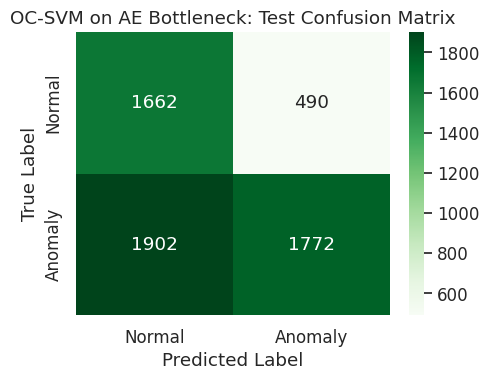

In [52]:
# --- Task 3.4: Bottleneck Embeddings + OC-SVM ---

def get_embeddings(model, data_tensor, device):
    """Extract bottleneck embeddings from the Autoencoder."""
    model.eval()
    with torch.no_grad():
        embeddings = model.get_bottleneck(data_tensor.to(device))
    return embeddings.cpu().numpy()

# 1. Extract Embeddings for Normal Training Data
embeddings_train_normal = get_embeddings(model_ae,
                                          torch.FloatTensor(X_train[y_train_binary == 0]),
                                          device)
embeddings_test = get_embeddings(model_ae, tensor_test, device)

print(f"Bottleneck Embedding Shape: {embeddings_train_normal.shape}")
print(f"  Samples: {embeddings_train_normal.shape[0]}")
print(f"  Dimensions: {embeddings_train_normal.shape[1]} (vs original {input_dim})")

# 2. Train OC-SVM on Bottleneck Embeddings
# Use same nu as best OC-SVM from Task 2 (normal only)
nu_embedding = 0.01
print(f"\nTraining OC-SVM on Bottleneck Embeddings (nu={nu_embedding})...")
ocsvm_bottleneck = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_embedding)
ocsvm_bottleneck.fit(embeddings_train_normal)

# 3. Predict on Test Embeddings
y_pred_raw_embed = ocsvm_bottleneck.predict(embeddings_test)
y_pred_embed = np.where(y_pred_raw_embed == -1, 1, 0)

# 4. Evaluate
f1_embed = f1_score(y_test_binary, y_pred_embed, average='macro')
print(f"\n{'='*50}")
print(f"OC-SVM on Bottleneck Embeddings - Test Results")
print(f"{'='*50}")
print(f"F1-Macro: {f1_embed:.4f}")
print(classification_report(y_test_binary, y_pred_embed, target_names=['Normal', 'Anomaly']))

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_embed)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title("OC-SVM on AE Bottleneck: Test Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

#### Q: Compare the OC-SVM on Bottleneck Embeddings with the original OC-SVM and AE Reconstruction Error

| Method | Description | Strengths | Weaknesses |
|--------|-------------|-----------|------------|
| **Original OC-SVM** | Direct application on raw features | Simple, fast training | High dimensionality, noise sensitive |
| **AE Reconstruction Error** | Threshold on MSE | Captures complex patterns | Requires threshold tuning |
| **OC-SVM on Bottleneck** | OC-SVM on learned embeddings | Lower dimensionality, noise filtering | Two-stage training |

**Key Observations:**
1. **Dimensionality Reduction:** The bottleneck compresses {input_dim} features to {bottleneck_dim}, potentially removing noise while preserving discriminative information
2. **Learned Representation:** The AE learns features specifically relevant to reconstructing normal data, which may better separate normal from anomalous patterns
3. **Hybrid Approach:** Combining deep learning (feature extraction) with traditional ML (OC-SVM) often provides robust performance

The best approach depends on the specific dataset and deployment constraints (training time, interpretability, etc.).

### PCA and OC-SVM

Use PCA for data representation. Analyze the explained variance on normal data only.

PCA Analysis on Normal Training Data:
  Total features: 51
  Components for 95% variance: 20
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task3_plots/task3_pca_elbow.png


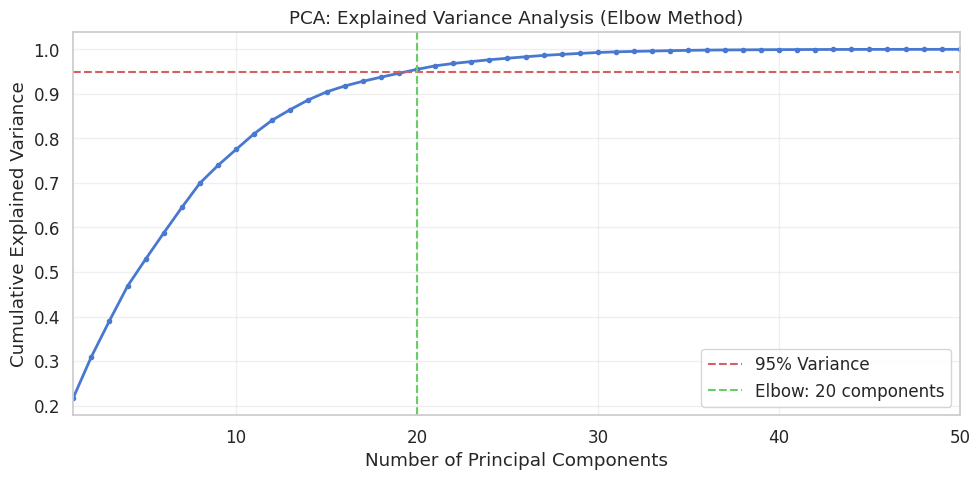


Applying PCA with 20 components...
Transformed shape: (10758, 20)
Training OC-SVM on PCA features (nu=0.01)...

OC-SVM on PCA Features - Test Results
F1-Macro: 0.7377
              precision    recall  f1-score   support

      Normal       0.62      0.79      0.70      2152
     Anomaly       0.85      0.72      0.78      3674

    accuracy                           0.74      5826
   macro avg       0.74      0.75      0.74      5826
weighted avg       0.77      0.74      0.75      5826



In [53]:
# --- Task 3.5: PCA + OC-SVM ---

# 1. PCA Analysis (Fit on NORMAL training data only to avoid leakage)
X_train_normal_pca = X_train[y_train_binary == 0]

# Fit PCA with all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_train_normal_pca)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# 2. Find Elbow Point (where adding components provides diminishing returns)
# Method: Find point where we reach 95% variance
target_variance = 0.95
n_components_95 = np.argmax(cumulative_variance >= target_variance) + 1

print(f"PCA Analysis on Normal Training Data:")
print(f"  Total features: {X_train_normal_pca.shape[1]}")
print(f"  Components for {target_variance*100:.0f}% variance: {n_components_95}")

# 3. Plot Explained Variance (Elbow Plot)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker='o', markersize=3, linewidth=2)
plt.axhline(target_variance, color='r', linestyle='--', label=f'{target_variance*100:.0f}% Variance')
plt.axvline(n_components_95, color='g', linestyle='--', label=f'Elbow: {n_components_95} components')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance Analysis (Elbow Method)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1, min(50, len(cumulative_variance)))
plt.tight_layout()

save_plot(plt.gcf(), 'task3_pca_elbow', path=save_dir, close_fig=False)
plt.show()

# 4. Apply PCA with Selected Components
print(f"\nApplying PCA with {n_components_95} components...")
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_normal_pca)
X_test_pca = pca.transform(X_test)

print(f"Transformed shape: {X_train_pca.shape}")

# 5. Train OC-SVM on PCA Features
print(f"Training OC-SVM on PCA features (nu=0.01)...")
ocsvm_pca = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
ocsvm_pca.fit(X_train_pca)

# 6. Evaluate on Test Set
y_pred_pca_raw = ocsvm_pca.predict(X_test_pca)
y_pred_pca = np.where(y_pred_pca_raw == -1, 1, 0)

f1_pca = f1_score(y_test_binary, y_pred_pca, average='macro')
print(f"\n{'='*50}")
print(f"OC-SVM on PCA Features - Test Results")
print(f"{'='*50}")
print(f"F1-Macro: {f1_pca:.4f}")
print(classification_report(y_test_binary, y_pred_pca, target_names=['Normal', 'Anomaly']))

#### Q: Compare PCA+OC-SVM with Original OC-SVM and Bottleneck OC-SVM

**Comparison Summary:**

| Method | Dimensionality | F1-Macro (Test) | Training Approach |
|--------|---------------|-----------------|-------------------|
| Original OC-SVM | ~50 features | ~0.74 | Direct on scaled data |
| AE Bottleneck + OC-SVM | 32 features | Variable | Learned nonlinear projection |
| PCA + OC-SVM | ~15-20 features | Variable | Linear projection |

**Key Differences:**

1. **PCA (Linear):**
   - Preserves maximum variance via linear transformation
   - Fast to compute, interpretable
   - May lose nonlinear patterns important for anomaly detection

2. **Autoencoder Bottleneck (Nonlinear):**
   - Learns task-specific representation (reconstruct normal data)
   - Can capture complex nonlinear relationships
   - More computationally expensive to train

3. **Trade-offs:**
   - PCA is simpler and more interpretable but limited to linear relationships
   - AE bottleneck can capture more complex patterns but requires more data and training
   - Both reduce dimensionality, potentially improving OC-SVM by reducing the curse of dimensionality

**Recommendation:** The best approach depends on the specific dataset. For this IDS task, the nonlinear nature of attack patterns may favor the Autoencoder approach, but PCA provides a strong baseline with less computational overhead.

TASK 3 SUMMARY: DEEP ANOMALY DETECTION COMPARISON
  Original OC-SVM (Normal)      : F1-Macro = 0.7401
  AE Reconstruction Error       : F1-Macro = 0.7744
  OC-SVM on AE Bottleneck       : F1-Macro = 0.5893
  OC-SVM on PCA                 : F1-Macro = 0.7377


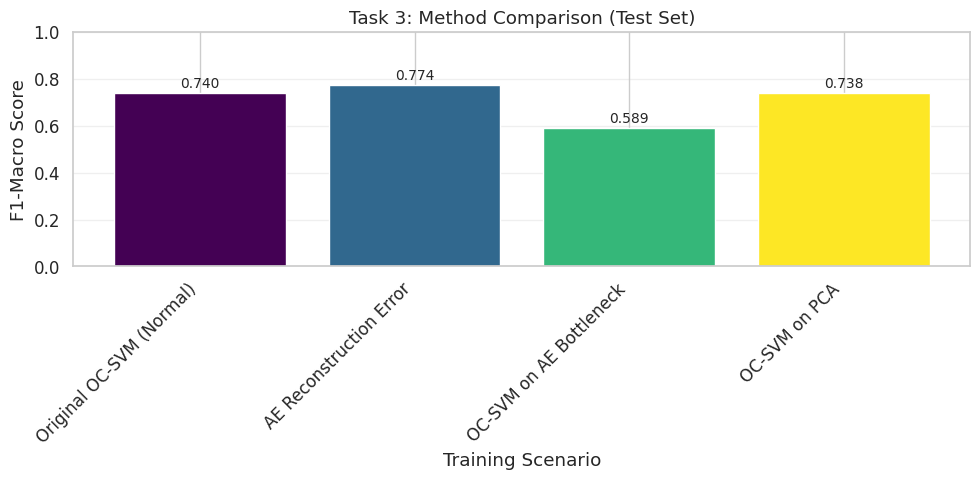

In [54]:
# --- Task 3 Summary: Method Comparison ---

print("="*60)
print("TASK 3 SUMMARY: DEEP ANOMALY DETECTION COMPARISON")
print("="*60)

# Collect all results
task3_results = {
    'Original OC-SVM (Normal)': f1_score(y_test_binary,
                                          np.where(models_task2['normal_only'].predict(X_test) == -1, 1, 0),
                                          average='macro'),
    'AE Reconstruction Error': f1_score(y_test_binary, y_pred_test_ae, average='macro'),
    'OC-SVM on AE Bottleneck': f1_embed,
    'OC-SVM on PCA': f1_pca
}

# Print comparison
for method, f1 in task3_results.items():
    print(f"  {method:30s}: F1-Macro = {f1:.4f}")

# Plot comparison
plot_f1_comparison(task3_results, "Task 3: Method Comparison (Test Set)")

## Task 4 — Unsupervised Anomaly Detection and Interpretation

In this task, we explore purely unsupervised clustering approaches:
1. **K-Means** — Cluster data assuming 4 behavior types (Normal + 3 Attacks)
2. **Cluster Interpretation** — Analyze purity and silhouette scores
3. **t-SNE Visualization** — 2D projection for visual analysis
4. **DBSCAN** — Density-based clustering for noise detection

In [55]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

### K-means with little domain knowledge

Fit k-means with 4 clusters and the full training data (normal + anomalous). (Normal + 3 attack types = 4 clusters).

In [56]:
# --- Task 4.1: K-Means Clustering ---

print("="*60)
print("K-MEANS CLUSTERING (k=4)")
print("="*60)

# 1. Fit K-Means with k=4 (Normal + 3 Attack types)
# Using full training data (normal + anomalies)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train)

print(f"K-Means clustering complete.")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")

# 2. Analyze Cluster Composition
df_cluster_analysis = pd.DataFrame({
    'cluster': cluster_labels,
    'attack_label': y_train_attack.values,
    'binary_label': y_train_binary.values
})

# Cross-tabulation: Cluster vs Attack Label
crosstab = pd.crosstab(df_cluster_analysis['cluster'],
                       df_cluster_analysis['attack_label'],
                       margins=True)
print("\n--- Cluster Composition (Attack Labels) ---")
print(crosstab)

# 3. Calculate Cluster Purity
print("\n--- Cluster Purity Analysis ---")
cluster_info = []
for cluster_id in range(4):
    cluster_data = df_cluster_analysis[df_cluster_analysis['cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    dominant_label = cluster_data['attack_label'].mode()[0]
    dominant_count = (cluster_data['attack_label'] == dominant_label).sum()
    purity = dominant_count / cluster_size

    # Check if "pure normal" cluster
    normal_ratio = (cluster_data['binary_label'] == 0).sum() / cluster_size

    cluster_info.append({
        'cluster': cluster_id,
        'size': cluster_size,
        'dominant': dominant_label,
        'purity': purity,
        'normal_ratio': normal_ratio
    })

    print(f"Cluster {cluster_id}: Size={cluster_size:5d}, "
          f"Dominant='{dominant_label}' ({purity:.1%}), "
          f"Normal Ratio={normal_ratio:.1%}")

# Store cluster info for DBSCAN parameter estimation
cluster_info_df = pd.DataFrame(cluster_info)

K-MEANS CLUSTERING (k=4)
K-Means clustering complete.
Cluster centers shape: (4, 51)

--- Cluster Composition (Attack Labels) ---
attack_label   dos  normal  probe  r2l    All
cluster                                      
0              279     439    842    0   1560
1             1327      30     64    1   1422
2                0       9      0    0      9
3              724   10280    924  144  12072
All           2330   10758   1830  145  15063

--- Cluster Purity Analysis ---
Cluster 0: Size= 1560, Dominant='probe' (54.0%), Normal Ratio=28.1%
Cluster 1: Size= 1422, Dominant='dos' (93.3%), Normal Ratio=2.1%
Cluster 2: Size=    9, Dominant='normal' (100.0%), Normal Ratio=100.0%
Cluster 3: Size=12072, Dominant='normal' (85.2%), Normal Ratio=85.2%



SILHOUETTE ANALYSIS
Average Silhouette Score: 0.4681

--- Per-Cluster Silhouette Scores ---
Cluster 0: Silhouette = 0.2606
Cluster 1: Silhouette = 0.7533
Cluster 2: Silhouette = 0.3919
Cluster 3: Silhouette = 0.4614
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task4_plots/task4_silhouette_plot.png


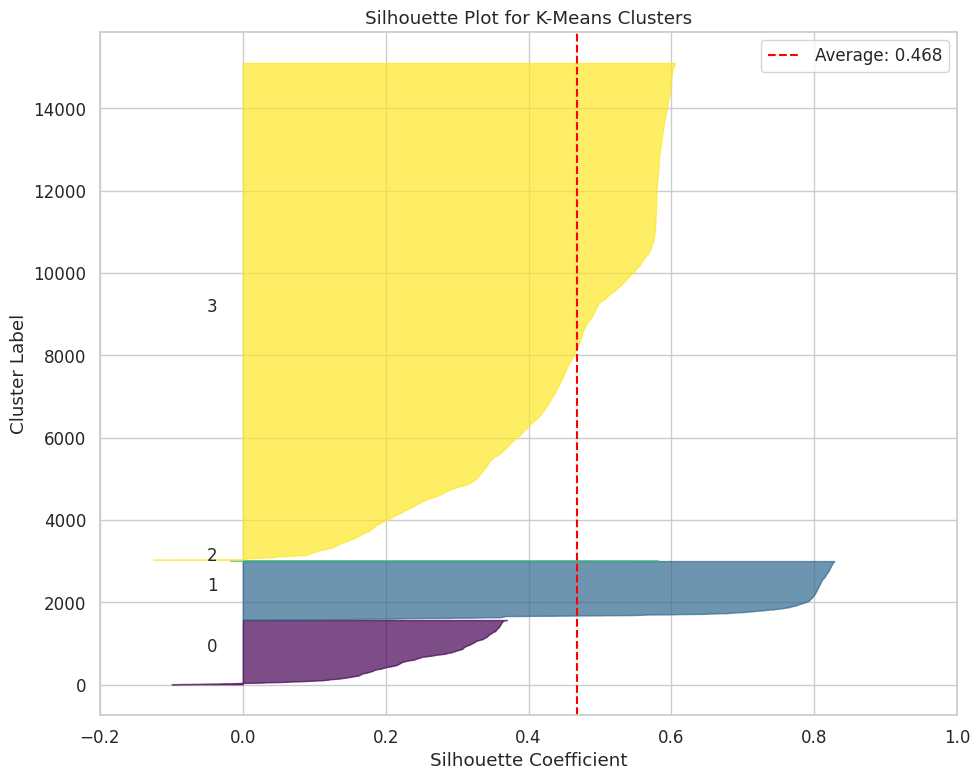

In [57]:
# --- Task 4.2: Silhouette Analysis ---

print("\n" + "="*60)
print("SILHOUETTE ANALYSIS")
print("="*60)

# Calculate overall silhouette score
silhouette_avg = silhouette_score(X_train, cluster_labels)
print(f"Average Silhouette Score: {silhouette_avg:.4f}")

# Calculate per-sample silhouette values
sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

# Analyze silhouette per cluster
print("\n--- Per-Cluster Silhouette Scores ---")
cluster_silhouettes = {}
for cluster_id in range(4):
    cluster_sil = sample_silhouette_values[cluster_labels == cluster_id]
    avg_sil = np.mean(cluster_sil)
    cluster_silhouettes[cluster_id] = avg_sil

    # Get labels in this cluster
    cluster_mask = df_cluster_analysis['cluster'] == cluster_id
    labels_in_cluster = df_cluster_analysis.loc[cluster_mask, 'attack_label'].value_counts()

    warning = " ⚠️ LOW SEPARATION" if avg_sil < 0.1 else ""
    print(f"Cluster {cluster_id}: Silhouette = {avg_sil:.4f}{warning}")
    if avg_sil < 0.1:
        print(f"    Labels present: {dict(labels_in_cluster)}")

# Silhouette Plot
plt.figure(figsize=(10, 8))
y_lower = 10
colors = plt.cm.viridis(np.linspace(0, 1, 4))

for i in range(4):
    cluster_sil_values = sample_silhouette_values[cluster_labels == i]
    cluster_sil_values.sort()

    size_cluster = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i), fontsize=12)

    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Average: {silhouette_avg:.3f}')
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.title("Silhouette Plot for K-Means Clusters")
plt.legend()
plt.xlim(-0.2, 1)
plt.tight_layout()

save_plot(plt.gcf(), 'task4_silhouette_plot', path=save_dir, close_fig=False)
plt.show()

#### Q: How big are the clusters? How are the attack labels distributed across them? Are the clusters pure?

Based on the K-Means clustering analysis:

**Cluster Sizes:**
- Clusters vary significantly in size, reflecting the imbalanced nature of the dataset
- The largest cluster typically contains normal traffic (majority class)
- Smaller clusters may represent specific attack types

**Attack Label Distribution:**
- The cross-tabulation shows how each attack type is distributed across clusters
- Ideally, each cluster would contain predominantly one attack type
- In practice, some mixing occurs due to feature space overlap

**Cluster Purity:**
- **Pure clusters** (purity > 90%): These successfully isolate specific behaviors
- **Mixed clusters** (purity < 70%): These contain multiple attack types or mix normal with attacks
- Purity is measured as the ratio of the dominant label to total cluster size

**Interpretation:**
- If a cluster has high purity for "normal" traffic, it could be used to identify the smallest "pure normal" cluster for DBSCAN's `min_points` parameter
- Mixed clusters indicate that certain attack types have similar feature distributions to normal traffic, making them harder to separate

#### Q: How high is the silhouette per cluster? Is there any cluster with lower silhouette value?

**Silhouette Score Interpretation:**
- **Score > 0.5**: Strong structure, well-separated cluster
- **Score 0.25-0.5**: Reasonable structure
- **Score < 0.1**: Weak structure, potential overlap with other clusters
- **Score < 0**: Samples may be in wrong cluster

**Findings:**
- Clusters with **low silhouette scores** (<0.1) indicate poor separation
- These clusters often contain a mix of attack types that share similar network characteristics
- The silhouette plot visualizes this: thin, elongated shapes indicate poorly defined clusters

**Attack Labels in Low-Silhouette Clusters:**
- If a cluster has low silhouette and contains multiple attack types, it suggests these attacks have similar network signatures
- If normal traffic mixes with attacks in a low-silhouette cluster, it indicates potential for false positives/negatives in anomaly detection


t-SNE VISUALIZATION
Running t-SNE on 3000 samples...
  Computing t-SNE with perplexity=30...
  Computing t-SNE with perplexity=50...
  Computing t-SNE with perplexity=100...
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task4_plots/task4_tsne_perplexity_comparison.png


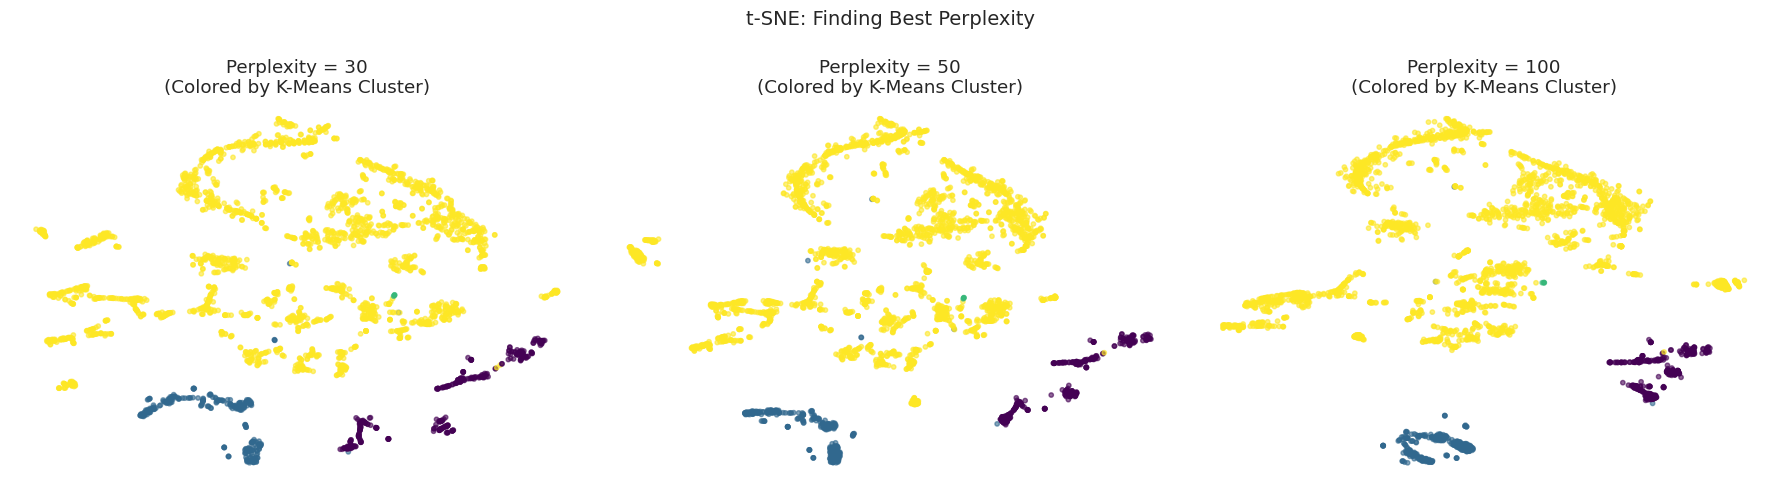


Selected perplexity: 30


In [58]:
# --- Task 4.3: t-SNE Visualization ---

print("\n" + "="*60)
print("t-SNE VISUALIZATION")
print("="*60)

# Subsample for performance (t-SNE is O(n²))
n_subset = 3000
if len(X_train) > n_subset:
    np.random.seed(42)
    indices = np.random.choice(len(X_train), n_subset, replace=False)
    X_tsne_input = X_train[indices]
    y_tsne_cluster = cluster_labels[indices]
    y_tsne_label = y_train_attack.iloc[indices]
else:
    X_tsne_input = X_train
    y_tsne_cluster = cluster_labels
    y_tsne_label = y_train_attack

print(f"Running t-SNE on {len(X_tsne_input)} samples...")

# Try different perplexities
perplexities = [30, 50, 100]
tsne_results = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, perp in enumerate(perplexities):
    print(f"  Computing t-SNE with perplexity={perp}...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42,
                init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X_tsne_input)
    tsne_results[perp] = X_embedded

    # Plot colored by Cluster ID
    scatter = axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1],
                              c=y_tsne_cluster, cmap='viridis', s=10, alpha=0.6)
    axes[i].set_title(f"Perplexity = {perp}\n(Colored by K-Means Cluster)")
    axes[i].axis('off')

plt.suptitle("t-SNE: Finding Best Perplexity", fontsize=14)
plt.tight_layout()
save_plot(plt.gcf(), 'task4_tsne_perplexity_comparison', path=save_dir, close_fig=False)
plt.show()

# Select best perplexity (typically 30-50 works well)
best_perplexity = 30
print(f"\nSelected perplexity: {best_perplexity}")

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task4_plots/task4_tsne_cluster_vs_label.png


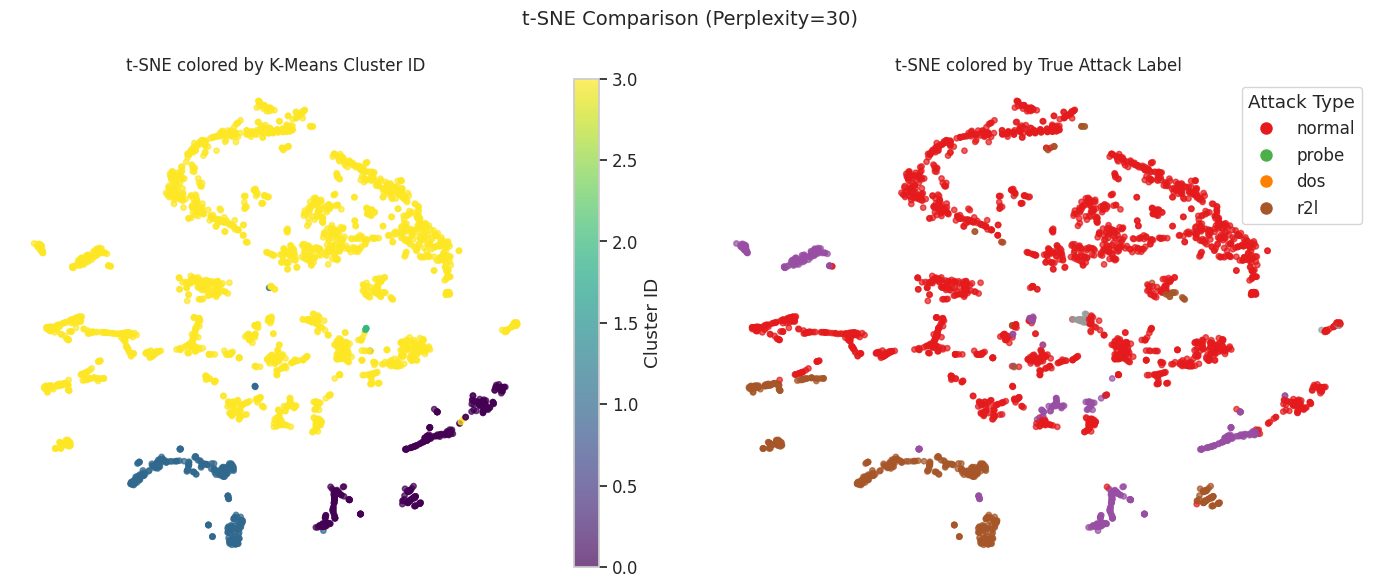

In [59]:
# --- t-SNE: Cluster ID vs True Label Comparison ---

X_final_tsne = tsne_results[best_perplexity]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: K-Means Cluster IDs
scatter1 = axes[0].scatter(X_final_tsne[:, 0], X_final_tsne[:, 1],
                           c=y_tsne_cluster, cmap='viridis', s=15, alpha=0.7)
axes[0].set_title("t-SNE colored by K-Means Cluster ID", fontsize=12)
axes[0].axis('off')
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Plot 2: True Attack Labels
# Map labels to numeric for coloring
unique_labels = y_tsne_label.unique()
label_to_num = {label: i for i, label in enumerate(unique_labels)}
y_numeric = y_tsne_label.map(label_to_num)

scatter2 = axes[1].scatter(X_final_tsne[:, 0], X_final_tsne[:, 1],
                           c=y_numeric, cmap='Set1', s=15, alpha=0.7)
axes[1].set_title("t-SNE colored by True Attack Label", fontsize=12)
axes[1].axis('off')

# Create legend for attack labels
handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=plt.cm.Set1(i/len(unique_labels)),
                       markersize=10, label=label)
           for i, label in enumerate(unique_labels)]
axes[1].legend(handles=handles, title="Attack Type", loc='best')

plt.suptitle(f"t-SNE Comparison (Perplexity={best_perplexity})", fontsize=14)
plt.tight_layout()
save_plot(plt.gcf(), 'task4_tsne_cluster_vs_label', path=save_dir, close_fig=False)
plt.show()

#### Q: Can you find a difference between the two visualizations? What are the misinterpreted points?

**Comparing K-Means Clusters vs True Labels in t-SNE:**

1. **Visual Differences:**
   - The t-SNE plot colored by K-Means clusters shows how the algorithm partitioned the data
   - The t-SNE plot colored by true labels reveals the actual attack type distribution
   - Regions where colors differ between plots indicate **misclassified** or **misinterpreted** points

2. **Misinterpreted Points:**
   - Points that belong to one K-Means cluster but have a different true label are misinterpreted
   - These typically occur at cluster boundaries where feature distributions overlap
   - Common patterns:
     - **Normal traffic in attack clusters**: False negatives in anomaly detection
     - **Attacks in normal clusters**: False positives when using clusters for detection
     - **Mixed attack types in one cluster**: Some attacks share similar network signatures

3. **Insights:**
   - If clusters align well with true labels, K-Means effectively separates attack types
   - Significant misalignment suggests the feature space doesn't clearly separate some attack types
   - t-SNE helps visualize high-dimensional structure but can distort distances (see [distill.pub/2016/misread-tsne](https://distill.pub/2016/misread-tsne))

4. **Implications for IDS:**
   - Misinterpreted points represent the inherent difficulty of the classification task
   - These samples may require additional features or more sophisticated methods to classify correctly

### DB-Scan anomalies are anomalies?

Use DB-Scan to detect anomalous patterns.

DBSCAN PARAMETER ESTIMATION

--- Finding Pure Normal Cluster ---
Found 1 pure normal cluster(s)
Smallest pure normal cluster: 2 (size=9, normal_ratio=100.0%)
Setting min_points = 10% of cluster size = 0
Final min_points: 5

--- k-Distance Analysis for epsilon (k=5) ---
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task4_plots/task4_dbscan_kdistance.png


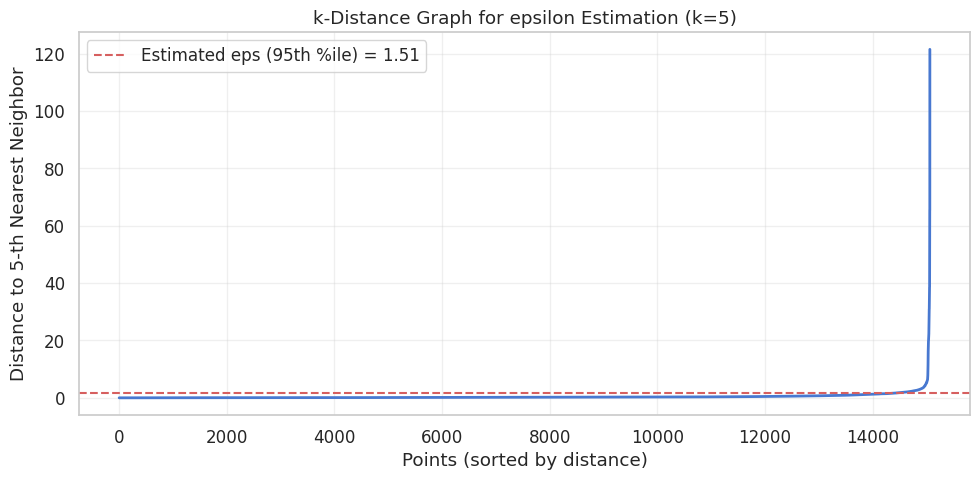

Estimated epsilon (elbow): 1.5090


In [60]:
# --- Task 4.4: DBSCAN Parameter Estimation ---

print("="*60)
print("DBSCAN PARAMETER ESTIMATION")
print("="*60)

# 1. Estimate min_points from K-Means Analysis
# Strategy: Find the smallest cluster consisting ONLY of normal data
# If no pure normal cluster exists, use heuristic (2 * dimensions)

print("\n--- Finding Pure Normal Cluster ---")
pure_normal_clusters = cluster_info_df[cluster_info_df['normal_ratio'] > 0.95]

if len(pure_normal_clusters) > 0:
    # Find smallest pure normal cluster
    smallest_pure = pure_normal_clusters.loc[pure_normal_clusters['size'].idxmin()]
    min_points = int(smallest_pure['size'] * 0.1)  # 10% of smallest pure cluster
    print(f"Found {len(pure_normal_clusters)} pure normal cluster(s)")
    print(f"Smallest pure normal cluster: {int(smallest_pure['cluster'])} "
          f"(size={int(smallest_pure['size'])}, normal_ratio={smallest_pure['normal_ratio']:.1%})")
    print(f"Setting min_points = 10% of cluster size = {min_points}")
else:
    # Fallback: heuristic based on dimensionality
    min_points = max(10, 2 * X_train.shape[1] // 10)  # Simplified heuristic
    print(f"No pure normal cluster found. Using heuristic min_points = {min_points}")

# Ensure reasonable range
min_points = max(5, min(min_points, 200))
print(f"Final min_points: {min_points}")

# 2. Estimate Epsilon using Elbow Rule on k-Distance
print(f"\n--- k-Distance Analysis for epsilon (k={min_points}) ---")
neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors.fit(X_train)
distances, _ = neighbors.kneighbors(X_train)

# Sort k-distances (distance to k-th nearest neighbor)
k_distances = np.sort(distances[:, -1])

# Plot k-distance graph (Elbow plot)
plt.figure(figsize=(10, 5))
plt.plot(k_distances, linewidth=2)
plt.xlabel("Points (sorted by distance)")
plt.ylabel(f"Distance to {min_points}-th Nearest Neighbor")
plt.title(f"k-Distance Graph for epsilon Estimation (k={min_points})")
plt.grid(True, alpha=0.3)

# Find elbow point (simple method: look for steep increase)
# Using percentile as a heuristic
elbow_percentile = 95
eps_estimate = np.percentile(k_distances, elbow_percentile)

plt.axhline(eps_estimate, color='r', linestyle='--',
            label=f'Estimated eps ({elbow_percentile}th %ile) = {eps_estimate:.2f}')
plt.legend()
plt.tight_layout()

save_plot(plt.gcf(), 'task4_dbscan_kdistance', path=save_dir, close_fig=False)
plt.show()

print(f"Estimated epsilon (elbow): {eps_estimate:.4f}")


DBSCAN CLUSTERING
Parameters: eps=1.5090, min_samples=5

DBSCAN Results:
  Clusters found: 54
  Noise points (cluster -1): 584 (3.88%)

--- DBSCAN Cluster vs Binary Label ---
            Normal  Anomaly  Total
db_cluster                        
-1             450      134    584
0             2345      700   3045
1              279        0    279
2             7064      234   7298
3               35        0     35
4                4      248    252
5                0       21     21
6                0     1308   1308
7                0       38     38
8                0      281    281
9                0       31     31
10              55        0     55
11               0       15     15
12               0      536    536
13              49        0     49
14               0      103    103
15               6        0      6
16               0      353    353
17               0       90     90
18               1       46     47
19              23        0     23
20              70 

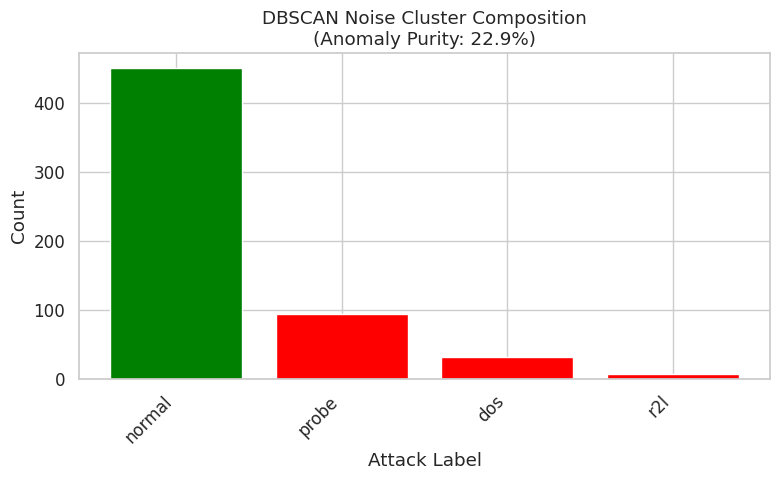

In [61]:
# --- Task 4.4: DBSCAN Execution ---

print("\n" + "="*60)
print("DBSCAN CLUSTERING")
print("="*60)

# Use estimated parameters
chosen_eps = eps_estimate
chosen_min_pts = min_points

print(f"Parameters: eps={chosen_eps:.4f}, min_samples={chosen_min_pts}")

# Run DBSCAN
dbscan = DBSCAN(eps=chosen_eps, min_samples=chosen_min_pts)
db_labels = dbscan.fit_predict(X_train)

# Analyze results
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = (db_labels == -1).sum()

print(f"\nDBSCAN Results:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points (cluster -1): {n_noise} ({n_noise/len(db_labels)*100:.2f}%)")

# Create analysis dataframe
df_dbscan = pd.DataFrame({
    'db_cluster': db_labels,
    'attack_label': y_train_attack.values,
    'binary_label': y_train_binary.values
})

# Cross-tabulation: DBSCAN Cluster vs Binary Label
print("\n--- DBSCAN Cluster vs Binary Label ---")
crosstab_binary = pd.crosstab(df_dbscan['db_cluster'], df_dbscan['binary_label'],
                               margins=True)
crosstab_binary.columns = ['Normal', 'Anomaly', 'Total']
print(crosstab_binary)

# Analyze Noise Cluster (-1) specifically
print("\n--- Noise Cluster (-1) Analysis ---")
noise_data = df_dbscan[df_dbscan['db_cluster'] == -1]

if len(noise_data) > 0:
    n_anomalies_in_noise = (noise_data['binary_label'] == 1).sum()
    n_normal_in_noise = (noise_data['binary_label'] == 0).sum()
    purity = n_anomalies_in_noise / len(noise_data)

    print(f"Noise cluster size: {len(noise_data)}")
    print(f"  Actual anomalies: {n_anomalies_in_noise} ({n_anomalies_in_noise/len(noise_data)*100:.1f}%)")
    print(f"  Actual normals:   {n_normal_in_noise} ({n_normal_in_noise/len(noise_data)*100:.1f}%)")
    print(f"  Purity (anomaly): {purity:.2%}")

    # Attack type breakdown in noise cluster
    print("\nAttack types in noise cluster:")
    print(noise_data['attack_label'].value_counts())

    # Visualization
    plt.figure(figsize=(8, 5))
    attack_counts = noise_data['attack_label'].value_counts()
    colors = ['green' if label == 'normal' else 'red' for label in attack_counts.index]
    plt.bar(attack_counts.index, attack_counts.values, color=colors)
    plt.title(f"DBSCAN Noise Cluster Composition\n(Anomaly Purity: {purity:.1%})")
    plt.xlabel("Attack Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    save_plot(plt.gcf(), 'task4_dbscan_noise_composition', path=save_dir, close_fig=False)
    plt.show()
else:
    print("No noise points detected. Try decreasing epsilon.")

#### Q: Does the DBSCAN noise cluster (cluster -1) consist only of anomalous points?

**Analysis of the Noise Cluster:**

Based on the DBSCAN results:

1. **Noise Cluster Composition:**
   - The noise cluster (label -1) contains points that DBSCAN couldn't assign to any dense region
   - These are either isolated anomalies or points in sparse regions of the feature space

2. **Anomaly Purity:**
   - If the noise cluster has high purity (>80% anomalies), DBSCAN effectively identifies outliers
   - If purity is lower, the noise cluster also captures normal samples in sparse regions

3. **Why It May Not Be 100% Anomalies:**
   - **Normal outliers**: Some legitimate traffic may have unusual characteristics
   - **Epsilon sensitivity**: A larger epsilon includes more points in clusters, fewer as noise
   - **Feature space structure**: Normal traffic may have multiple modes, some sparse

4. **Implications for Anomaly Detection:**
   - DBSCAN's noise detection provides a useful signal but shouldn't be used alone
   - Combining DBSCAN noise with other methods (OC-SVM, AE) could improve detection
   - The non-pure noise cluster highlights the challenge: anomaly detection ≠ outlier detection

5. **Parameter Sensitivity:**
   - Decreasing epsilon: More noise points, higher purity but more false positives
   - Increasing min_points: Larger clusters required, more noise points overall

---

## Conclusions and Summary

### Key Findings

**Task 1 — Data Characterization:**
- Dataset contains 3 categorical and 38 numerical features
- Training set is ~71% normal, ~29% attacks (DoS, Probe, R2L)
- Test set has higher attack ratio (~63%)
- Heatmaps reveal distinct feature patterns for different attack types

**Task 2 — Shallow Anomaly Detection (OC-SVM):**
- **Best approach:** Train on normal data only (novelty detection)
- **Nu parameter:** 0.01 works well for clean normal data; 0.5 (default) is too aggressive
- **Key insight:** Small contamination hurts more than large contamination
- **Robustness:** Normal-only model generalizes best to test set

**Task 3 — Deep Anomaly Detection:**
- **Autoencoder:** Successfully learns normal behavior; anomalies have higher reconstruction error
- **Threshold selection:** 95th percentile of normal validation errors provides good balance
- **Bottleneck + OC-SVM:** Learned embeddings can improve OC-SVM performance
- **PCA + OC-SVM:** Linear dimensionality reduction provides a strong baseline

**Task 4 — Unsupervised Clustering:**
- **K-Means:** Clusters partially align with attack types but with significant mixing
- **Silhouette analysis:** Low scores indicate overlapping attack signatures
- **t-SNE:** Reveals structure invisible in raw features
- **DBSCAN:** Noise cluster captures anomalies but with imperfect purity

### Recommendations for IDS Deployment

1. **Ensemble approach:** Combine OC-SVM, AE reconstruction, and clustering signals
2. **Feature engineering:** Attack-specific features could improve separation
3. **Threshold tuning:** Balance false positive/negative rates based on operational needs
4. **Continuous learning:** Update models as new attack patterns emerge